In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import cv2
from cycler import cycler
import matplotlib.colors as mcolors
import os

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 2.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#aaaaaa"
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]



## Зависимость температуры от тока для всего диапазона измерений длинной вольфрамовой нити

In [21]:
T = lambda I: 108.0958765*I*I*I-511.9765339*I*I+1617.95649045*I+537.60415503

## Обработка искажений
Используется 8 изображений из каталога `calib`, на которых изображён один и тот же равномерно нагретый участок нити в разных частях изображения.

### Искажения матрицы и линзы

Цель -- получить матрицу коэффициентов чувствительности матрицы по всей её плоскости

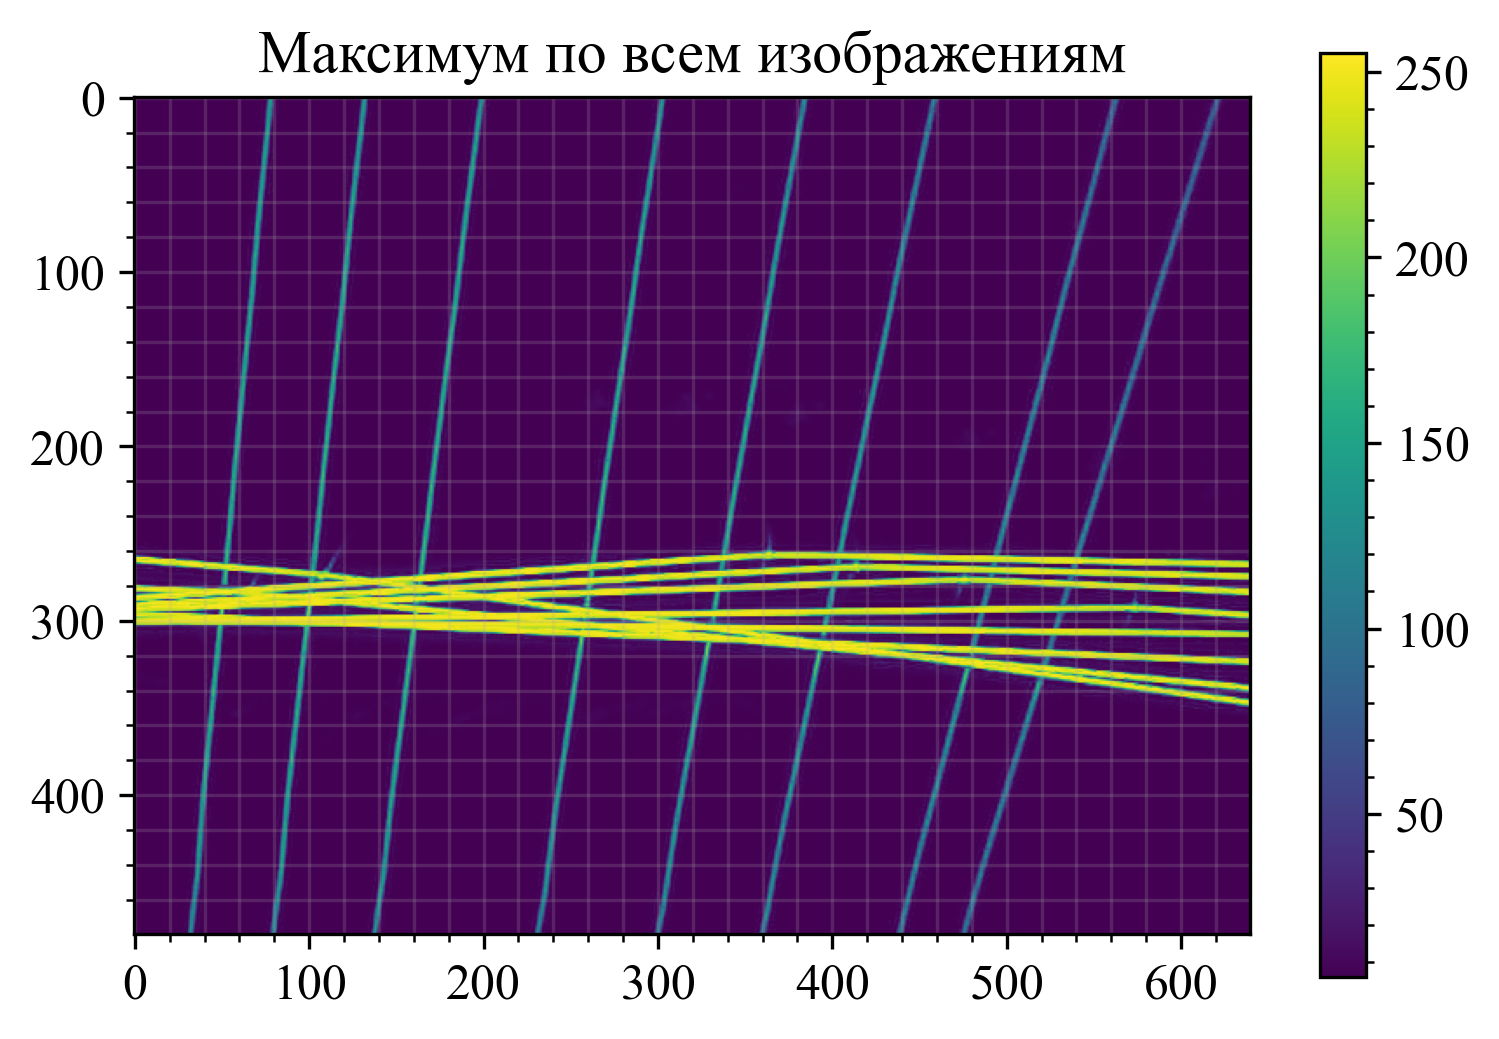

In [22]:
images = np.array([cv2.imread(f"calib/{i}_1400_original.png", cv2.IMREAD_GRAYSCALE) for i in range(1, 9)])
image_max = np.maximum.reduce(images)

plt.imshow(image_max)
plt.title('Максимум по всем изображениям')
plt.colorbar()
plt.show()

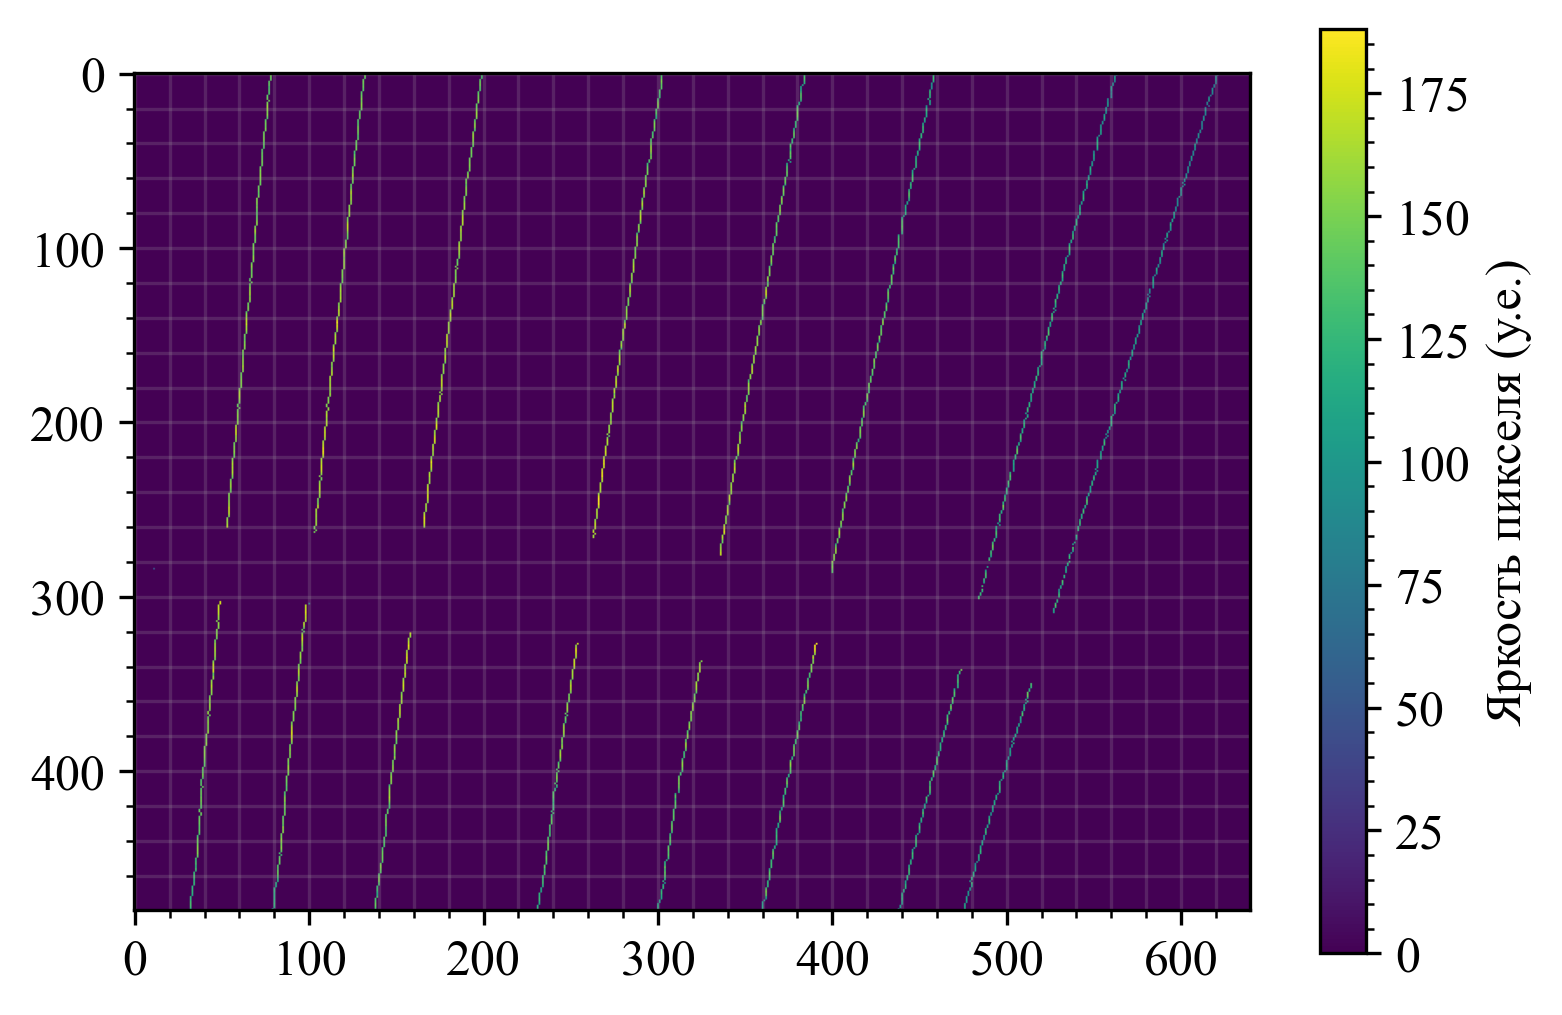

In [23]:
upper_lim = 190
lower_lim = 40
window_shift = 20
wire_shift = 0

for image in images:
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] > upper_lim:
                image[i-window_shift:i+window_shift, j-window_shift:j+window_shift] = 0
        max_j = image[i].argmax()
        image[i, :max_j-wire_shift] = 0
        image[i, max_j+wire_shift+1:] = 0

image_max = np.maximum.reduce(images)
image_filter = np.where((image_max > lower_lim) & (image_max < upper_lim), image_max, np.zeros_like(image_max))

plt.imshow(image_filter)
# plt.title('')
plt.colorbar(label='Яркость пикселя (у.е.)')
plt.show()

In [24]:
def surface2d(coefficients, x_grid, y_grid):
    return coefficients[0] + \
    coefficients[1] * x_grid + \
    coefficients[2] * y_grid + \
    coefficients[3] * x_grid**2 + \
    coefficients[4] * x_grid * y_grid + \
    coefficients[5] * y_grid**2

def fit_2d_polynomial_and_calibrate(image):
    """
    Аппроксимирует двумерный полином второго порядка по ненулевым пикселям
    """
    # 1. Находим координаты ненулевых пикселей
    nonzero_indices = np.nonzero(image)
    y_coords, x_coords = nonzero_indices
    z_values = image[y_coords, x_coords]
    
    # 2. Создаем матрицу признаков для полинома второго порядка
    # Для формулы: a₀ + a₁x + a₂y + a₃x² + a₄xy + a₅y²
    X = np.column_stack([
        np.ones_like(x_coords),  # a₀
        x_coords,                # a₁
        y_coords,                # a₂
        x_coords**2,             # a₃
        x_coords * y_coords,     # a₄
        y_coords**2              # a₅
    ])
    
    # 3. Решаем систему линейных уравнений методом наименьших квадратов
    coefficients, _, _, _ = np.linalg.lstsq(X, z_values)
    
    # 4. Создаем сетку координат для всего изображения
    height, width = image.shape
    y_grid, x_grid = np.mgrid[0:height, 0:width]
    
    # 5. Вычисляем значения полинома для каждого пикселя изображения
    poly_surface = surface2d(coefficients, x_grid, y_grid)
    
    return (x_coords, y_coords, z_values), coefficients, poly_surface


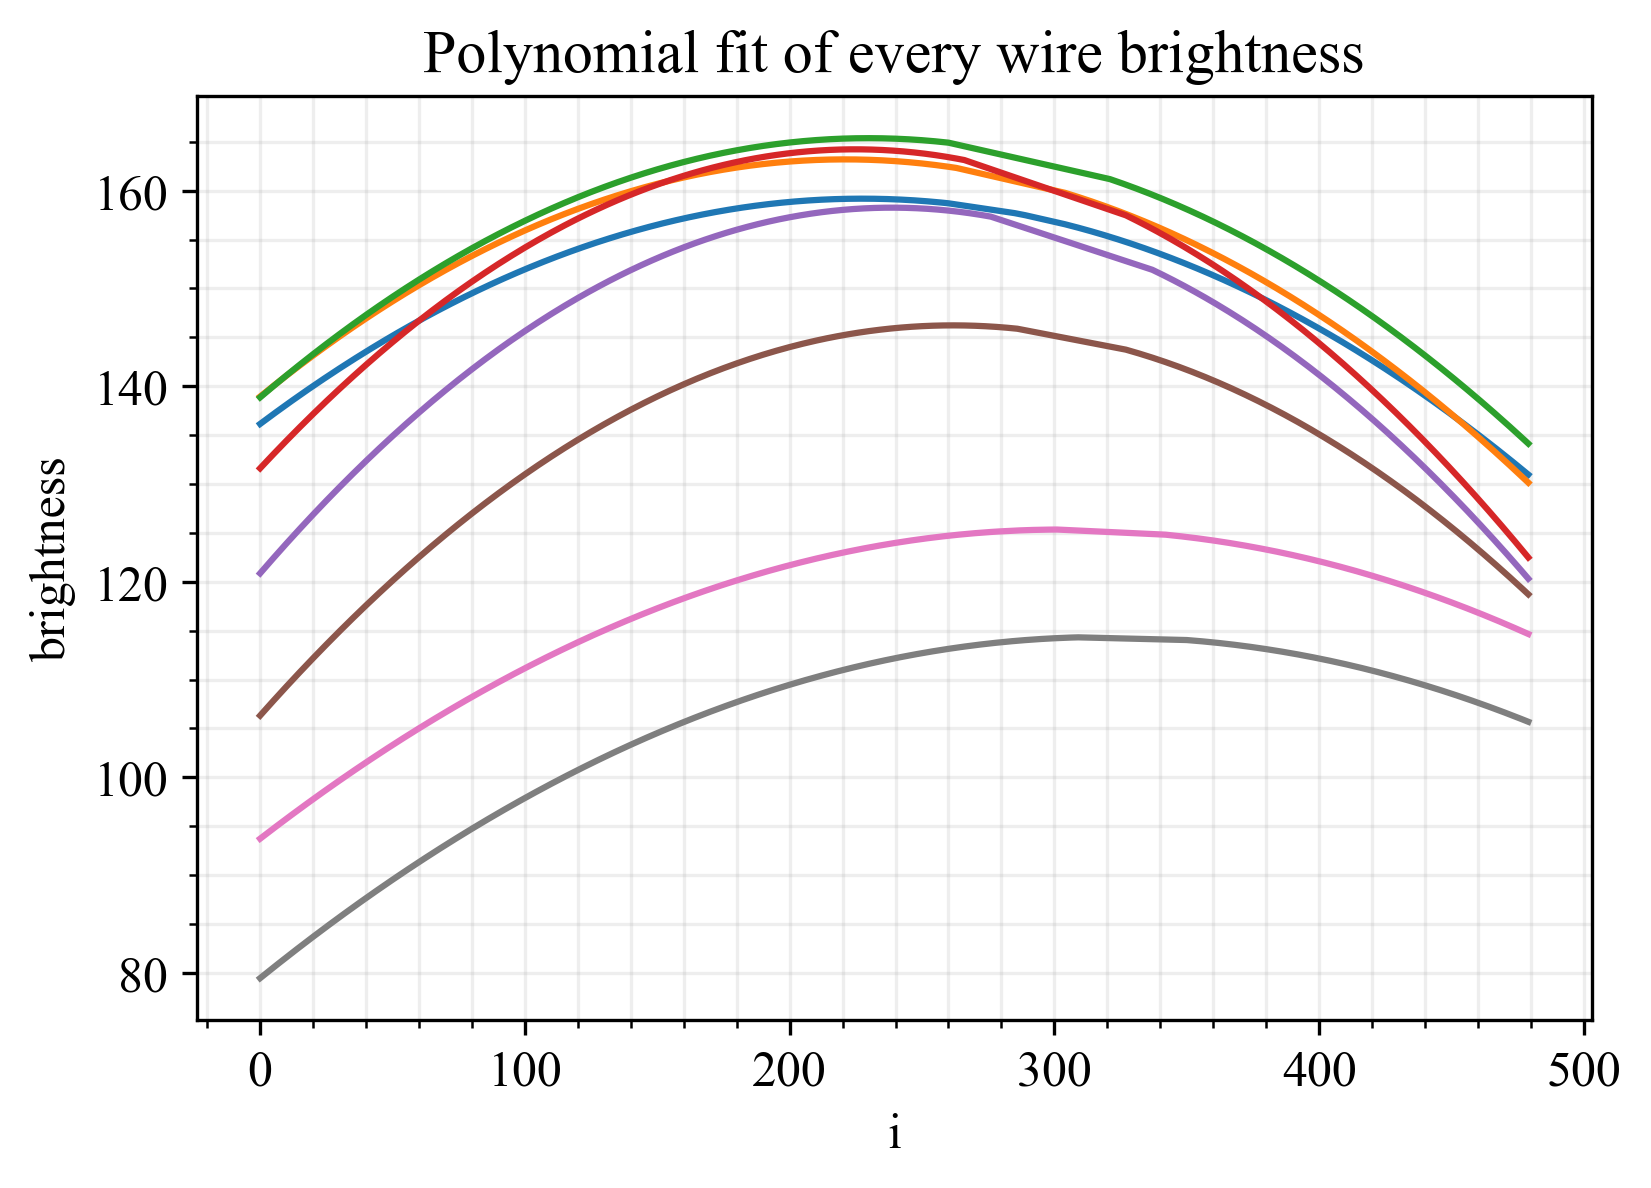

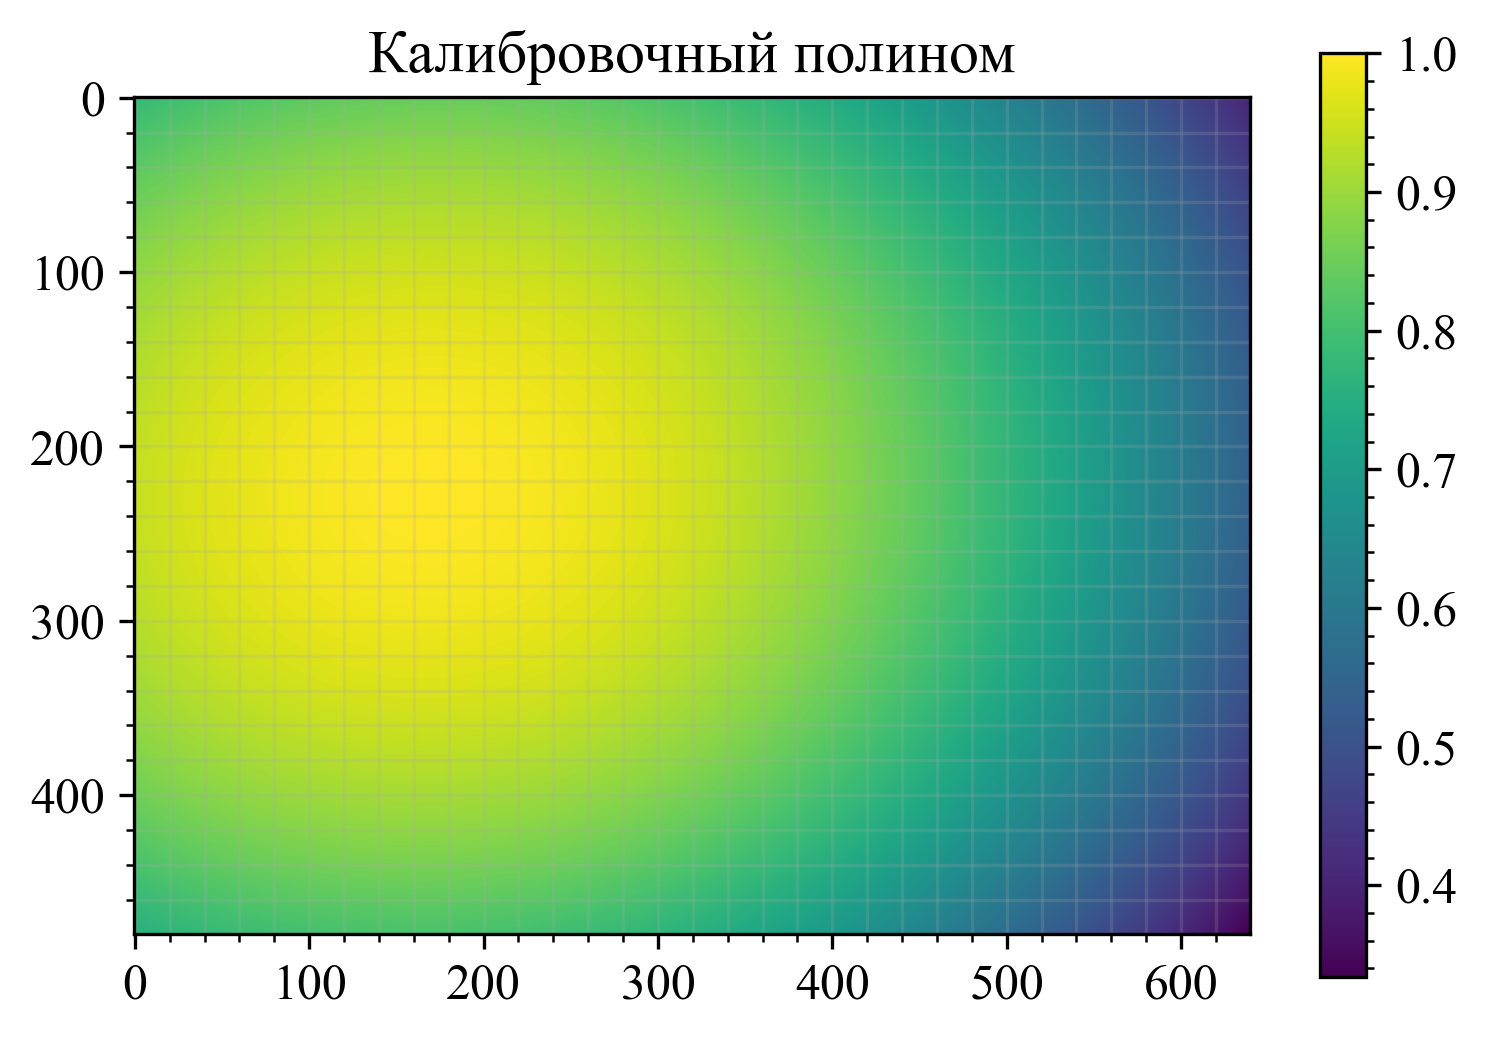

In [25]:
image_poly = np.zeros_like(images[0])
deg = 2

for image in images:
    # plt.ylim(0, 255)
    
    i_arr = np.arange(image.shape[0])
    j_max = np.argmax(image, axis=1)
    Y_arr = image[i_arr, j_max]
    idx = (Y_arr > 40)

    i = i_arr[idx]
    j = j_max[idx]
    Y = Y_arr[idx]
    popt, pcov = np.polyfit(i, Y, deg, cov=True)
    p = np.poly1d(popt)

    # plt.scatter(i, Y, s=1)
    plt.plot(i, p(i))

    image_poly[i, j] = p(i)

plt.title('Polynomial fit of every wire brightness')
plt.xlabel('i')
plt.ylabel('brightness')
plt.show()

(x_coords, y_coords, z_values), coeffs, poly_surface = fit_2d_polynomial_and_calibrate(image_poly.copy())

calib_surface = poly_surface.copy() / np.max(poly_surface)

plt.imshow(calib_surface)
plt.title('Калибровочный полином')
plt.colorbar()
plt.show()

## Градуировка по нитям

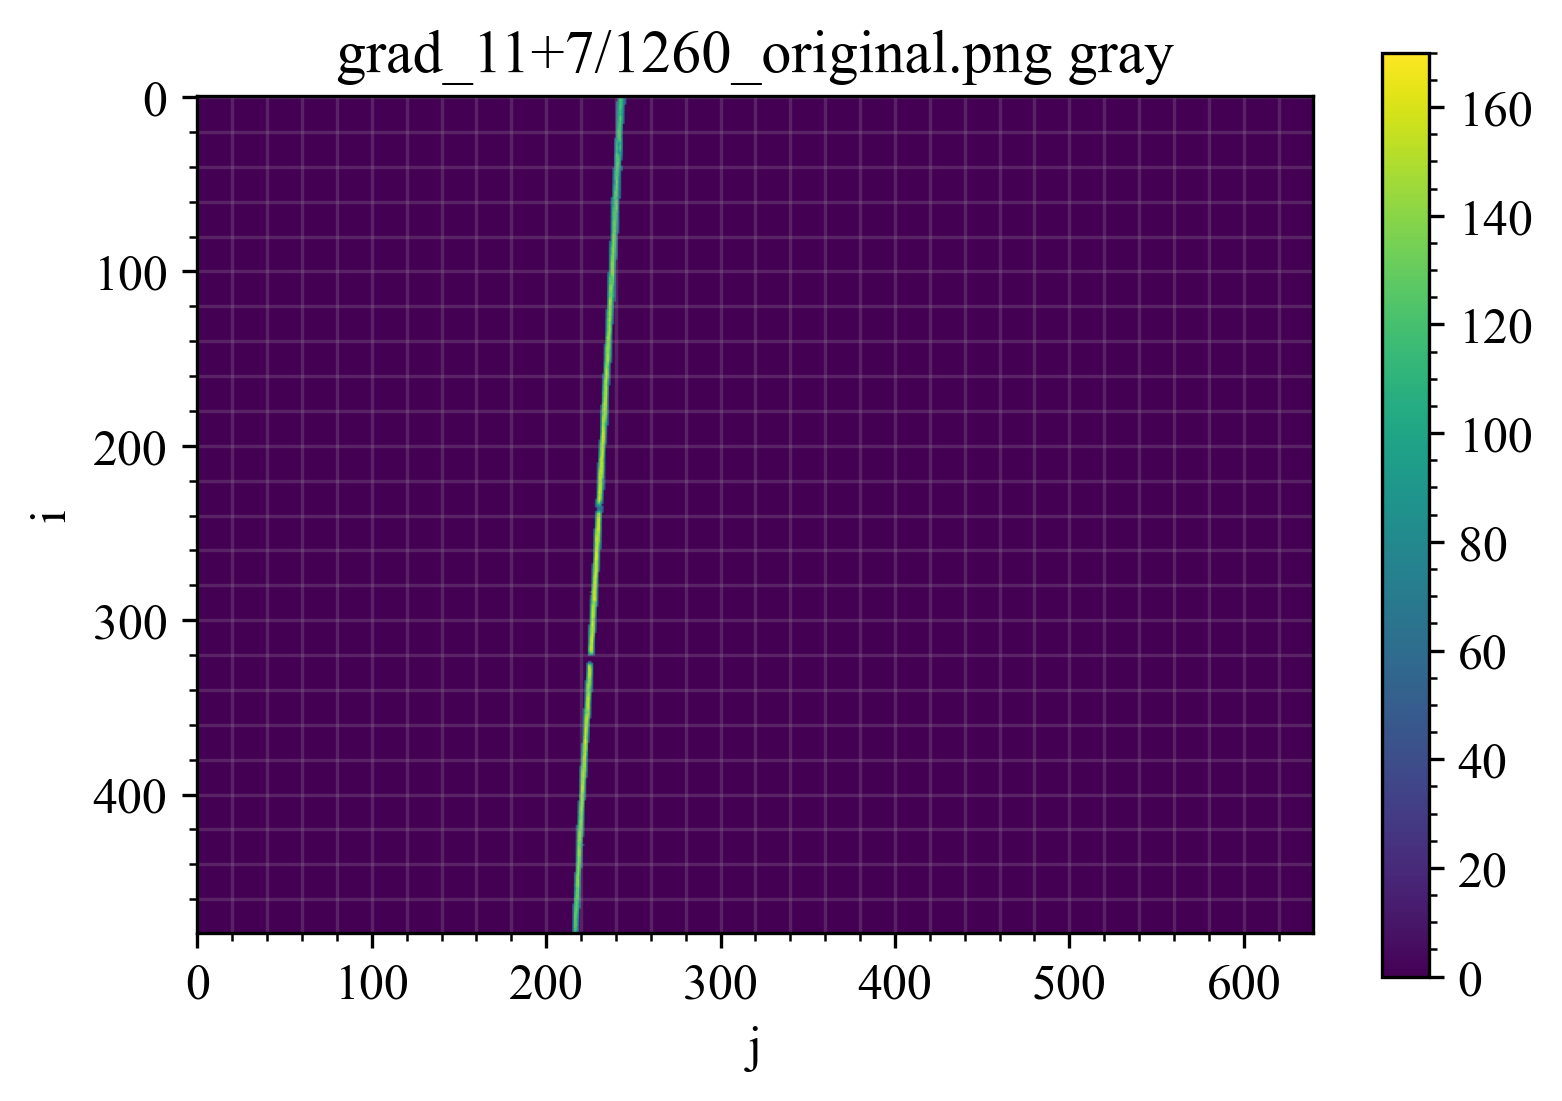

In [26]:
image_name = 'grad_11+7/1260_original.png'
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

image[image < 40] = 0
# image = image.astype(np.float64) / calib_surface 

plt.xlabel('j')
plt.ylabel('i')
plt.imshow(image)
plt.colorbar()
plt.title(image_name + ' gray')
plt.show()

### Яркость в максимуме и яркость на оси в зависимости от i (одиночные пиксели)

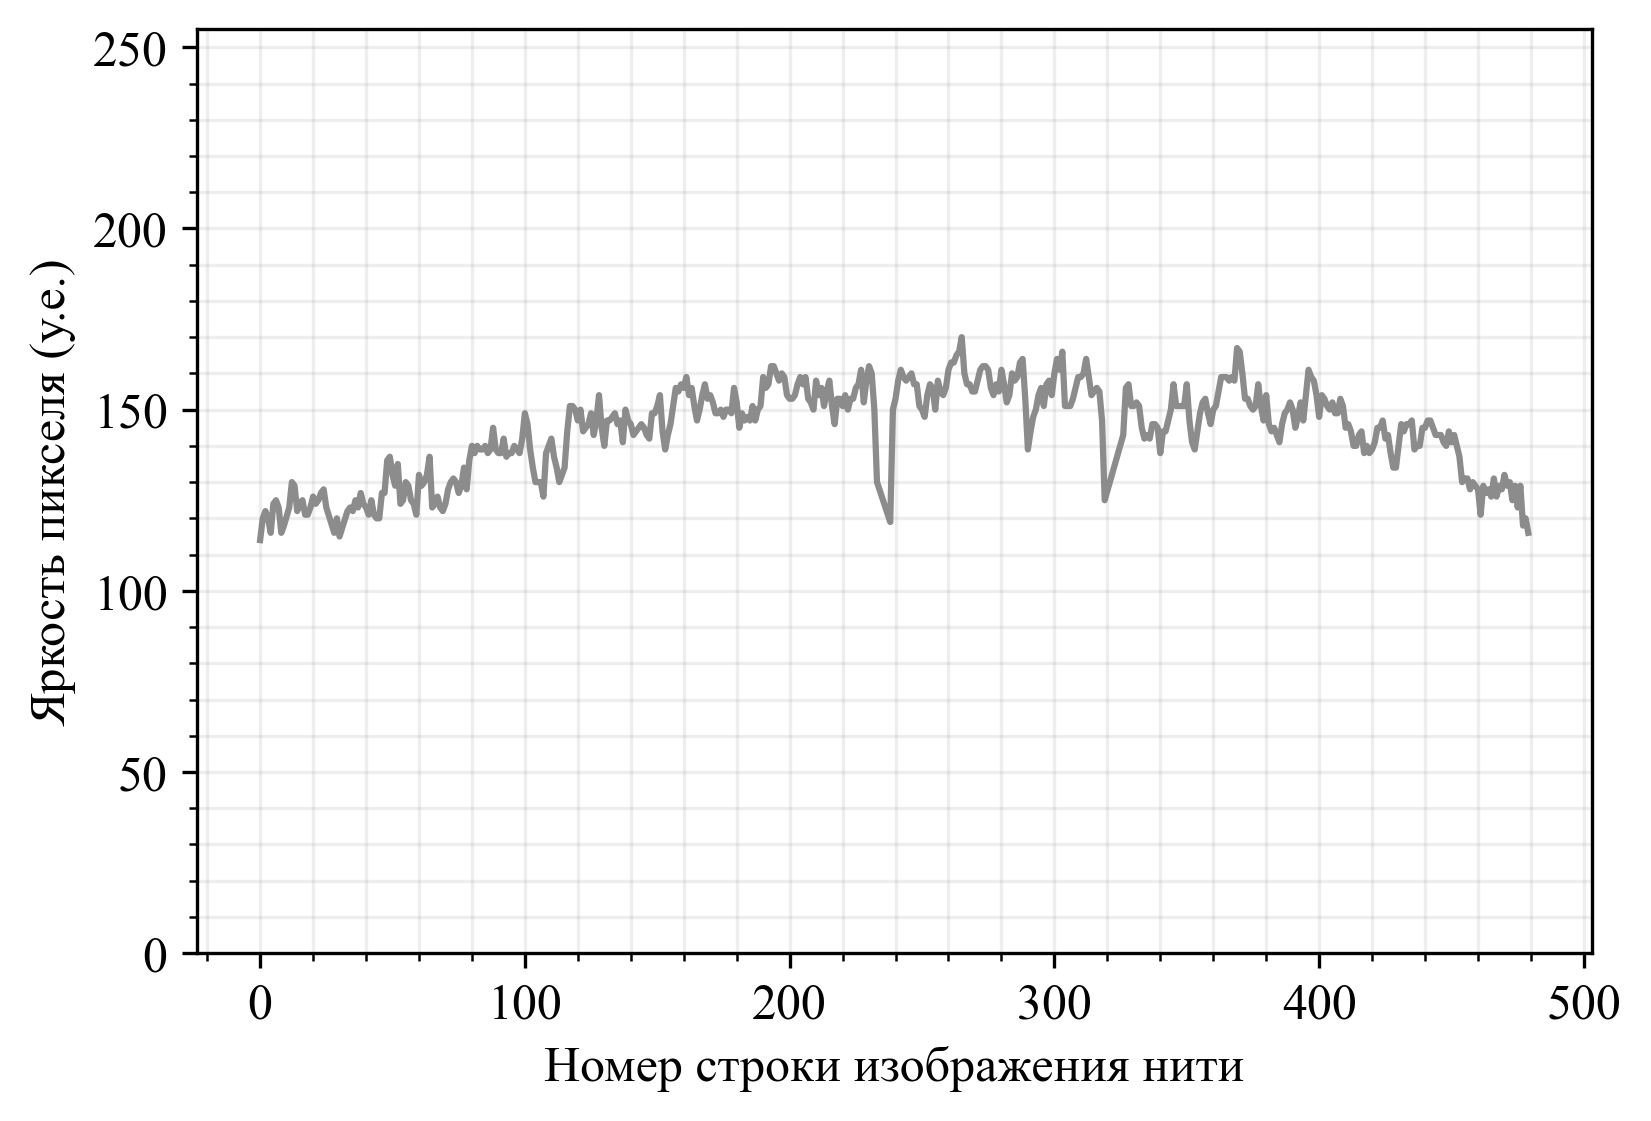

mean: 144.44, std: 12.36


In [27]:
color = 'gray'
fit_order = 1

def j_maxs(img_array):
    res = []
    for i in range(img_array.shape[0]):
        res.append(np.argmax(img_array[i]))
    return np.array(res)

def wire_brightness(img_array, plot=False):
    i_arr = np.arange(img_array.shape[0])
    j_max = j_maxs(img_array)
    Y_max = image[i_arr, j_max]

    idx = (Y_max > Y_max.mean() * .8)
    i_arr = i_arr[idx]
    j_max = j_max[idx]
    Y_max = image[i_arr, j_max]

    if plot:
        plt.ylim(0, 255)
        plt.plot(i_arr, Y_max, color=color, label='$Y_{макс}$', alpha=.9)

        plt.xlabel('Номер строки изображения нити')
        plt.ylabel('Яркость пикселя (у.е.)')
        # plt.legend()
        plt.show()

    return np.mean(Y_max), np.std(Y_max)

mean, std = wire_brightness(image, plot=True)
print(f'mean: {mean:.2f}, std: {std:.2f}')

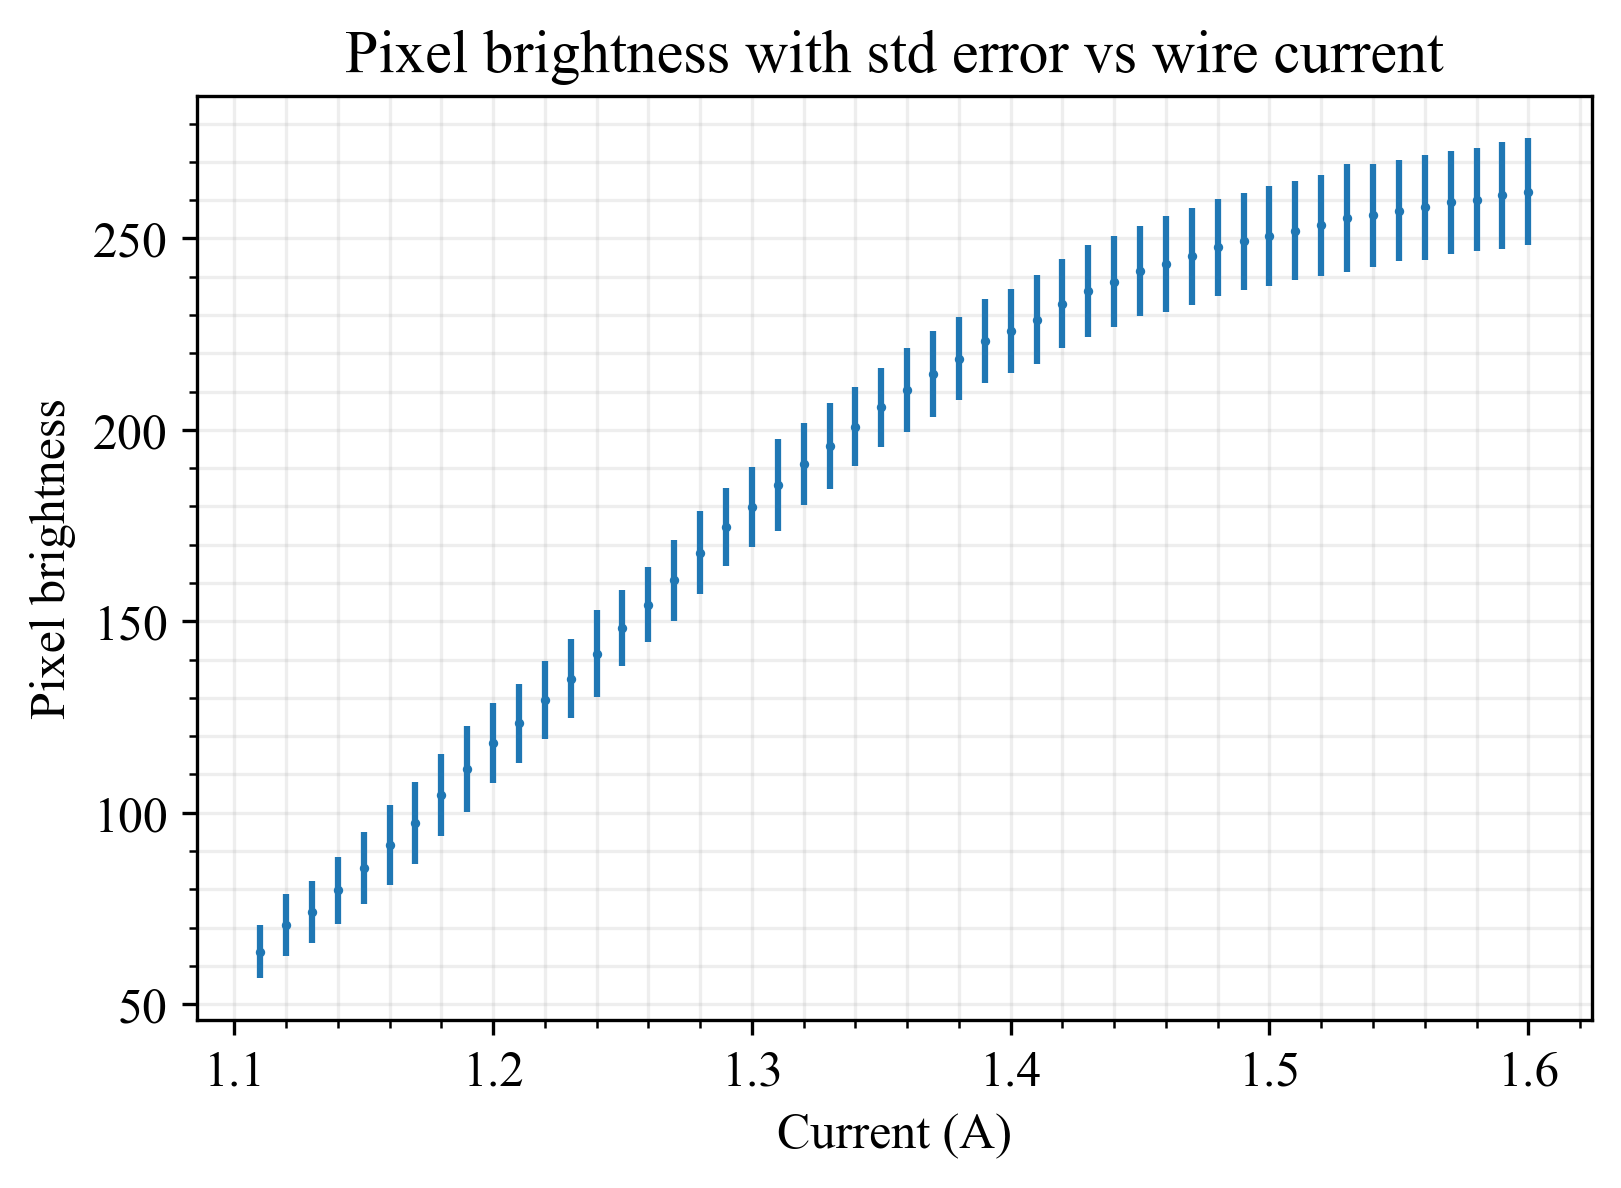

In [28]:
current_array = []
mean_bri_array = []
std_bri_array = []

dirname = 'grad_11+7'
for file in os.listdir(dirname):
    filename = os.fsdecode(file)
    current_array.append(float(filename.split('_')[0]))

    image = cv2.imread(dirname + '/' + filename, cv2.IMREAD_GRAYSCALE)
    image[image < 40] = 0
    image = image.astype(np.float64) / calib_surface 
    mean, std = wire_brightness(image)
    mean_bri_array.append(mean)
    std_bri_array.append(std)

current_array = np.array(current_array) / 1000
mean_bri_array = np.array(mean_bri_array)
std_bri_array = np.array(std_bri_array)

plt.errorbar(current_array, mean_bri_array, std_bri_array, fmt='.')
plt.xlabel('Current (A)')
plt.ylabel('Pixel brightness')
plt.title('Pixel brightness with std error vs wire current')
plt.show()

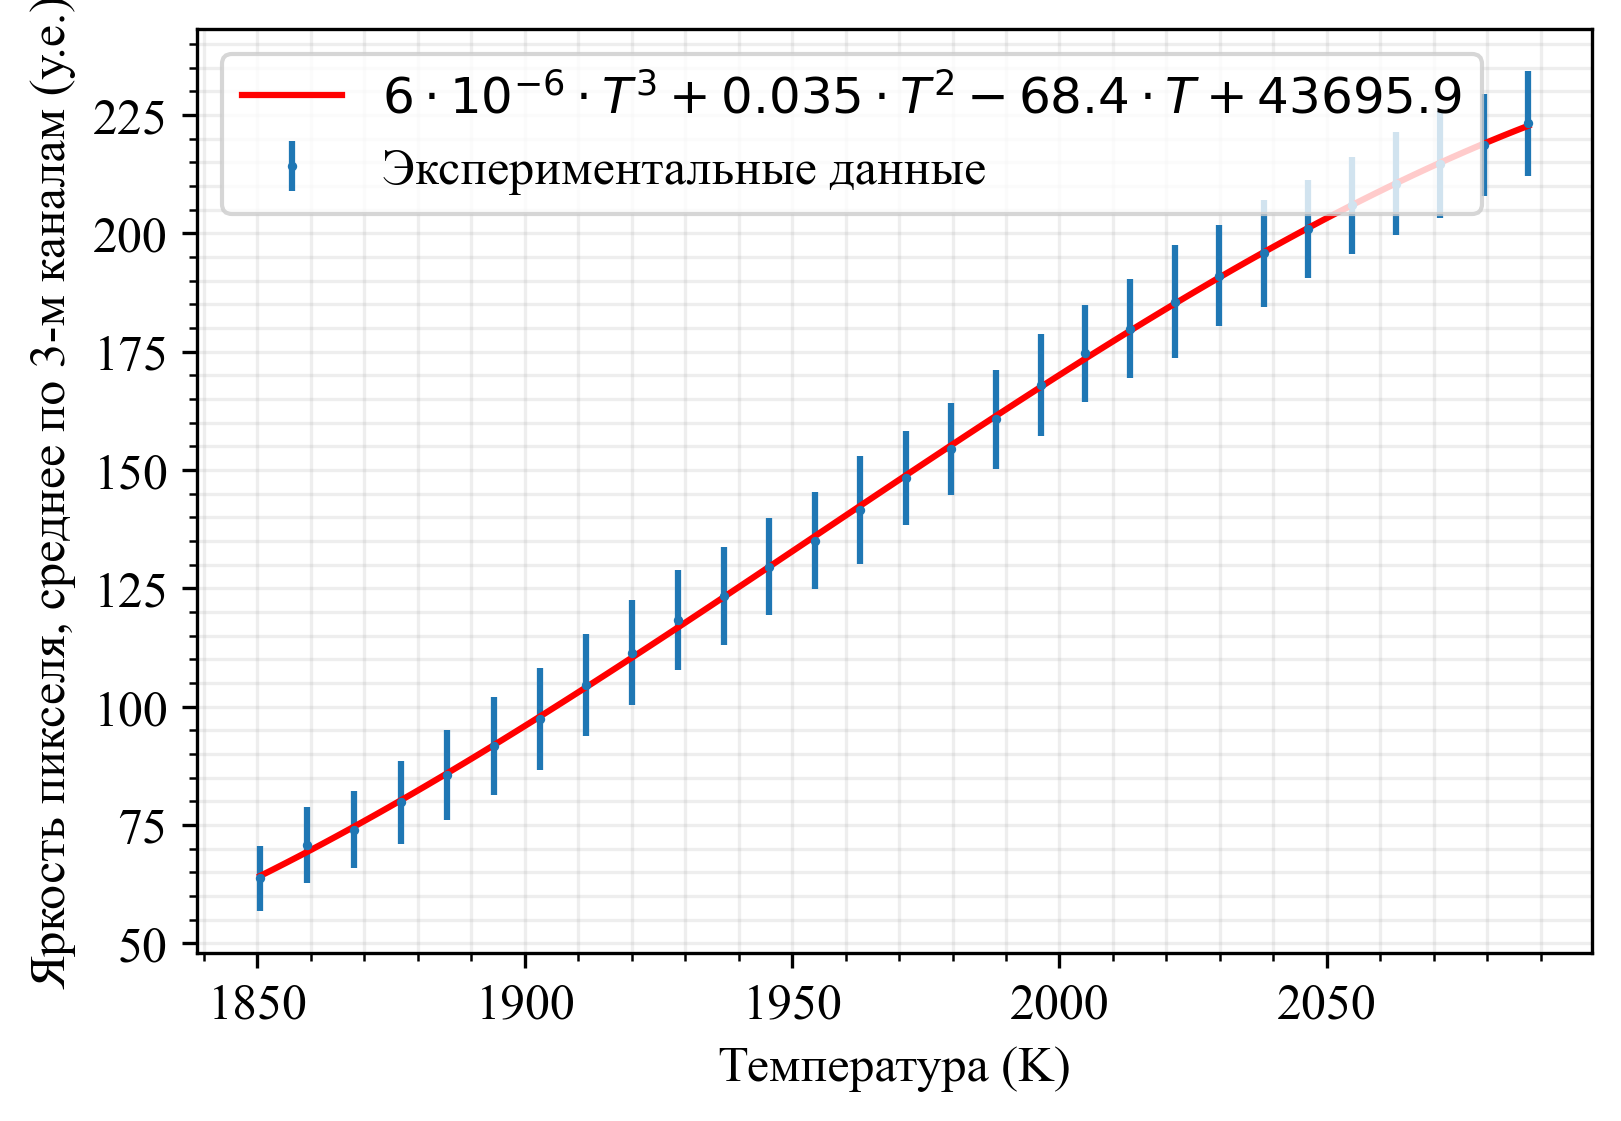

            3           2
-6.034e-06 x + 0.03538 x - 68.38 x + 4.37e+04


In [29]:
temperature_array = T(current_array)

fit_order = 3

idx = mean_bri_array < 225
plt.errorbar(temperature_array[idx], mean_bri_array[idx], std_bri_array[idx], fmt='.', label='Экспериментальные данные')

popt, pcov = np.polyfit(temperature_array[idx], mean_bri_array[idx], fit_order, cov=True)
p = np.poly1d(popt)
x = np.linspace(temperature_array[idx].min(), temperature_array[idx].max(), 100)
plt.plot(x, p(x), 'r', label='$6\\cdot 10^{-6} \\cdot T^3' + f' + {p[2]:.3f} \\cdot T^2 {p[1]:.1f} \\cdot T + {p[0]:.1f}$')

plt.xlabel('Температура (K)')
plt.ylabel('Яркость пикселя, среднее по 3-м каналам (у.е.)')
plt.legend()
plt.show()

print(p)

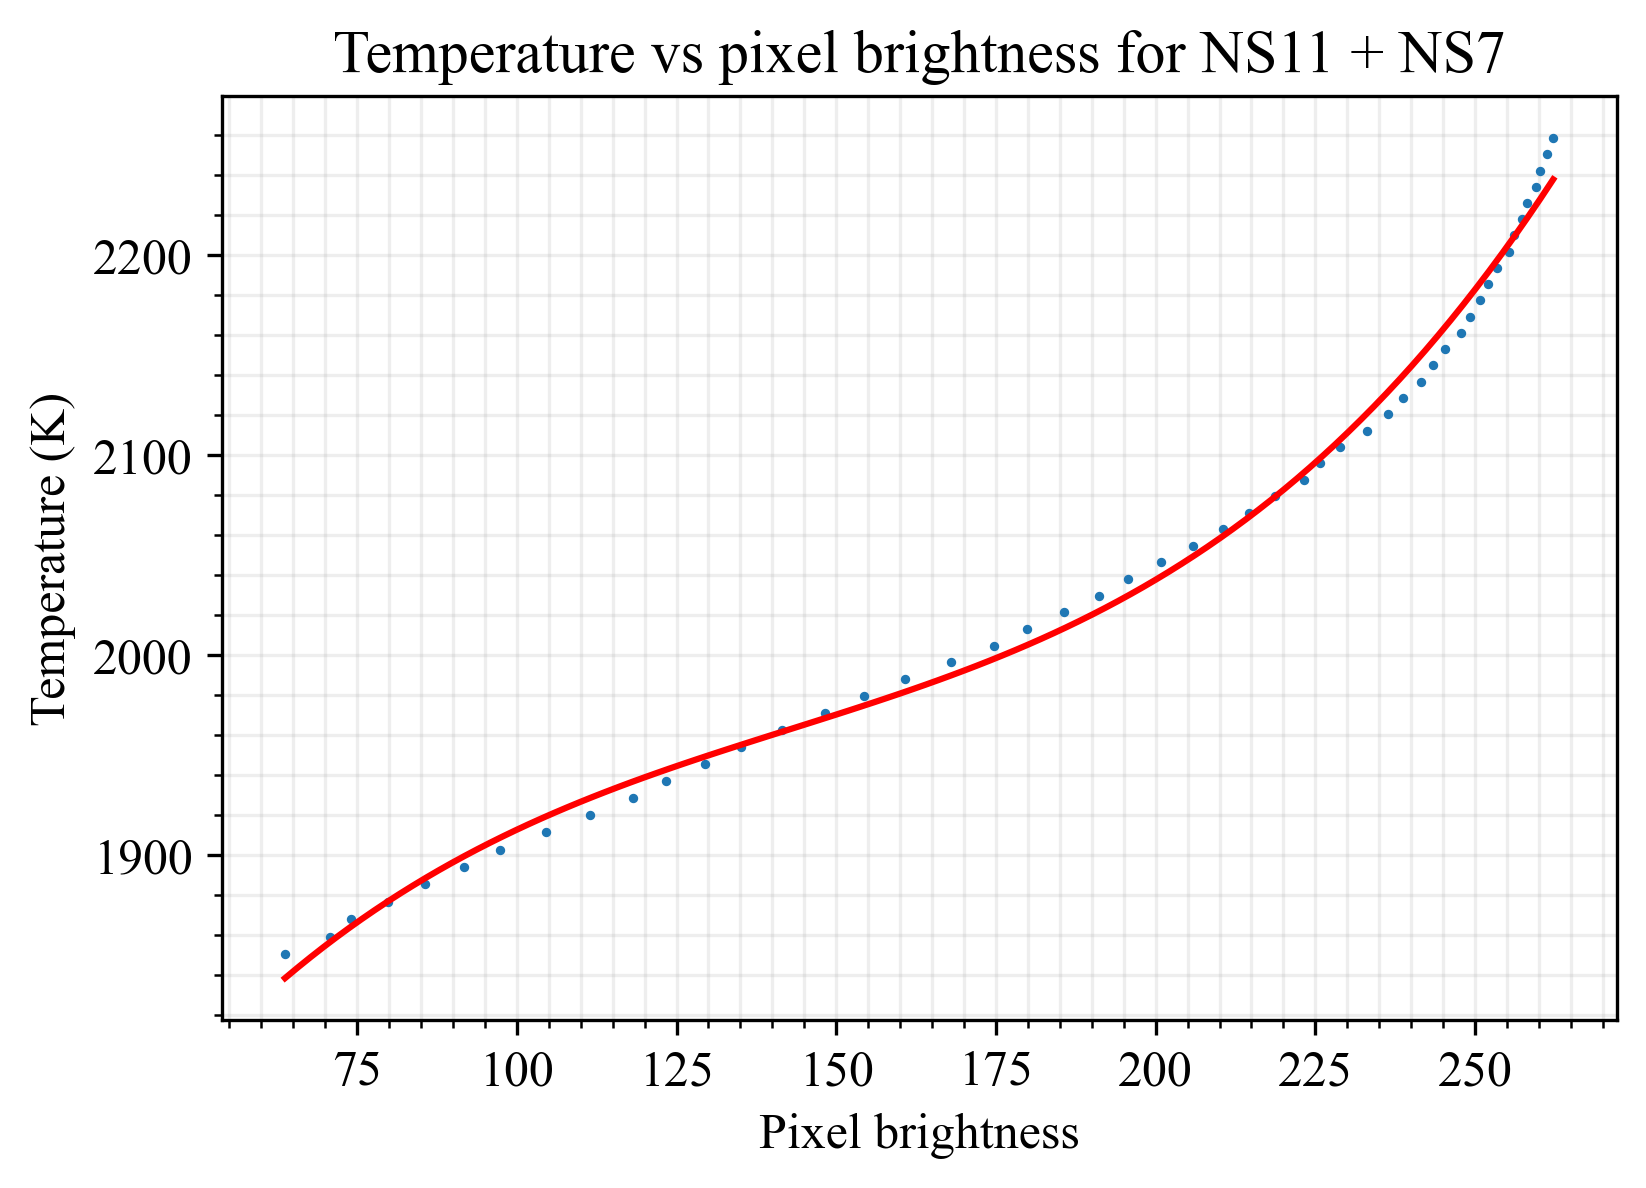

           3           2
9.045e-05 x - 0.03873 x + 6.538 x + 1556


In [30]:
popt, pcov = np.polyfit(mean_bri_array, temperature_array, fit_order, cov=True)
p = np.poly1d(popt)

plt.plot(mean_bri_array, temperature_array, '.')
x = np.linspace(mean_bri_array.min(), mean_bri_array.max(), 100)
plt.plot(x, p(x), 'r')
plt.xlabel('Pixel brightness')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs pixel brightness for NS11 + NS7')
plt.show()

print(p)

T_bri_11_7 = p
# T_bri_11 = lambda bri: T_bri_11_7(bri) - 128
# T_bri_11_8 = lambda bri: T_bri_11_7(bri) + 128

## Обработка изображения катода

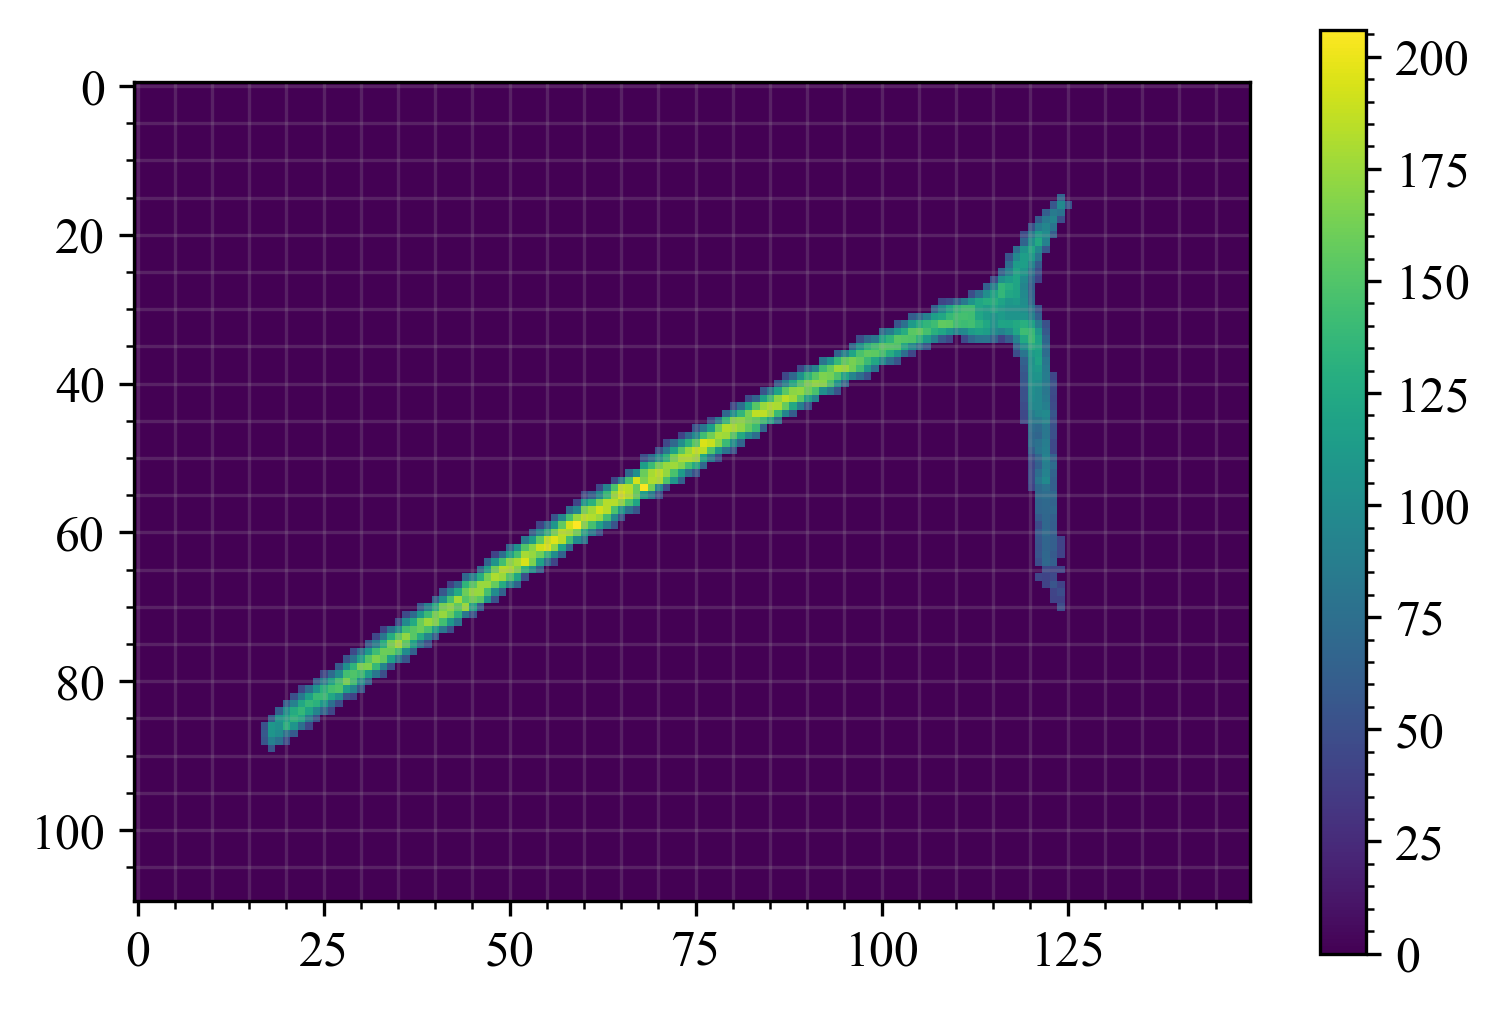

In [31]:
image = cv2.imread('cathode_11/ns11_1500ma_original.png', cv2.IMREAD_GRAYSCALE)
image[image < 40] = 0
image = image.astype(np.float64) / calib_surface
image = image[170:280, 180:330]

plt.imshow(image)
plt.colorbar()
plt.show()

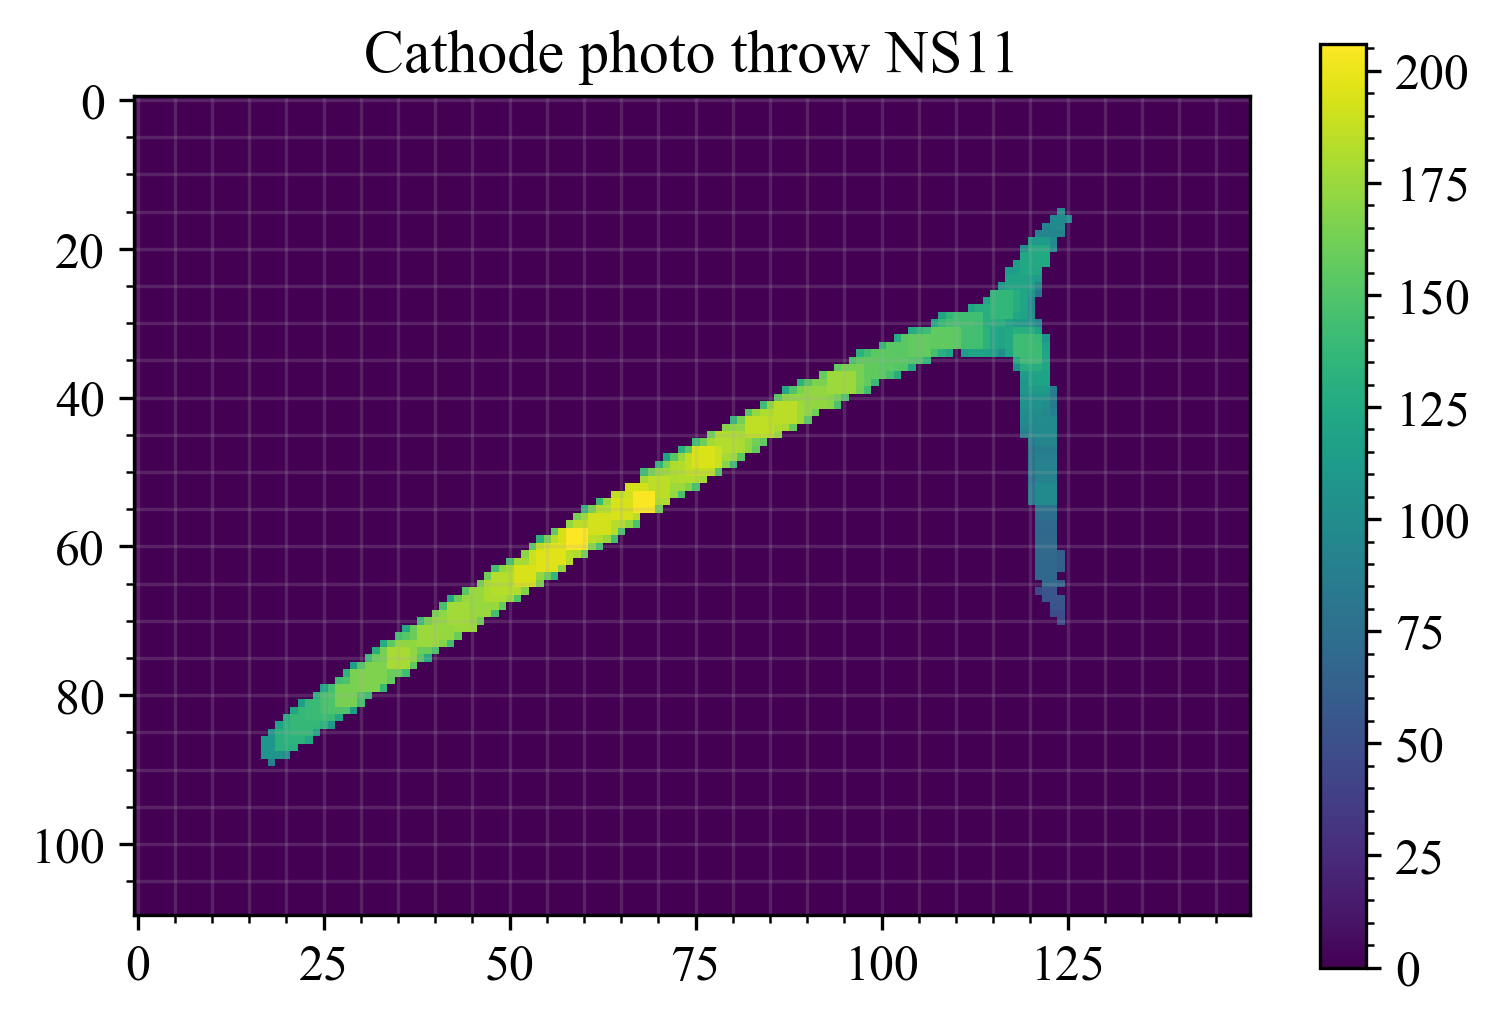

In [32]:
image_filtered = np.zeros_like(image)
filter_func = np.max
shift = 1

for i in range(1, image.shape[0] - 1):
    for j in range(1, image.shape[1] - 1):
        if image[i, j] == 0:
            continue
        image_filtered[i, j] = filter_func(image[i-shift:i+1+shift, j-shift:j+1+shift])

plt.imshow(image_filtered)
plt.title('Cathode photo throw NS11')
plt.colorbar()
plt.show()

In [33]:
# temperature_map = T_bri_11(image_filtered)
# temperature_map[image_filtered == 0] = temperature_map.min() * .99

# plt.imshow(temperature_map, cmap='hot')
# plt.title('Temperature map')
# plt.colorbar()
# plt.show()

In [34]:
def get_temperature_map(filename, T_bri_func, original=True, plot=False):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    image[image < 40] = 0
    if original:
        image = image.astype(np.float64) / calib_surface
        image = image[180:300, 215:330]

    image_filtered = np.zeros_like(image)
    filter_func = np.max
    shift = 1

    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i, j] == 0:
                continue
            image_filtered[i, j] = filter_func(image[i-shift:i+1+shift, j-shift:j+1+shift])

    temperature_map = T_bri_func(image_filtered)
    # temperature_map[image_filtered == 0] = temperature_map.min() * .99
    temperature_map[image_filtered == 0] = 1500

    if plot:
        plt.imshow(temperature_map, cmap='hot')
        plt.clim(1500, 2200)
        plt.colorbar(label='Температура (K)')
        # plt.title(filename)
        # plt.title('Тепловая карта катода')
        plt.show()

    return temperature_map

In [35]:
# _ = get_temperature_map(f'cathode_11+7/1700_60_roi.png', T_bri_11_7, plot=True, original=False)

1700 mA


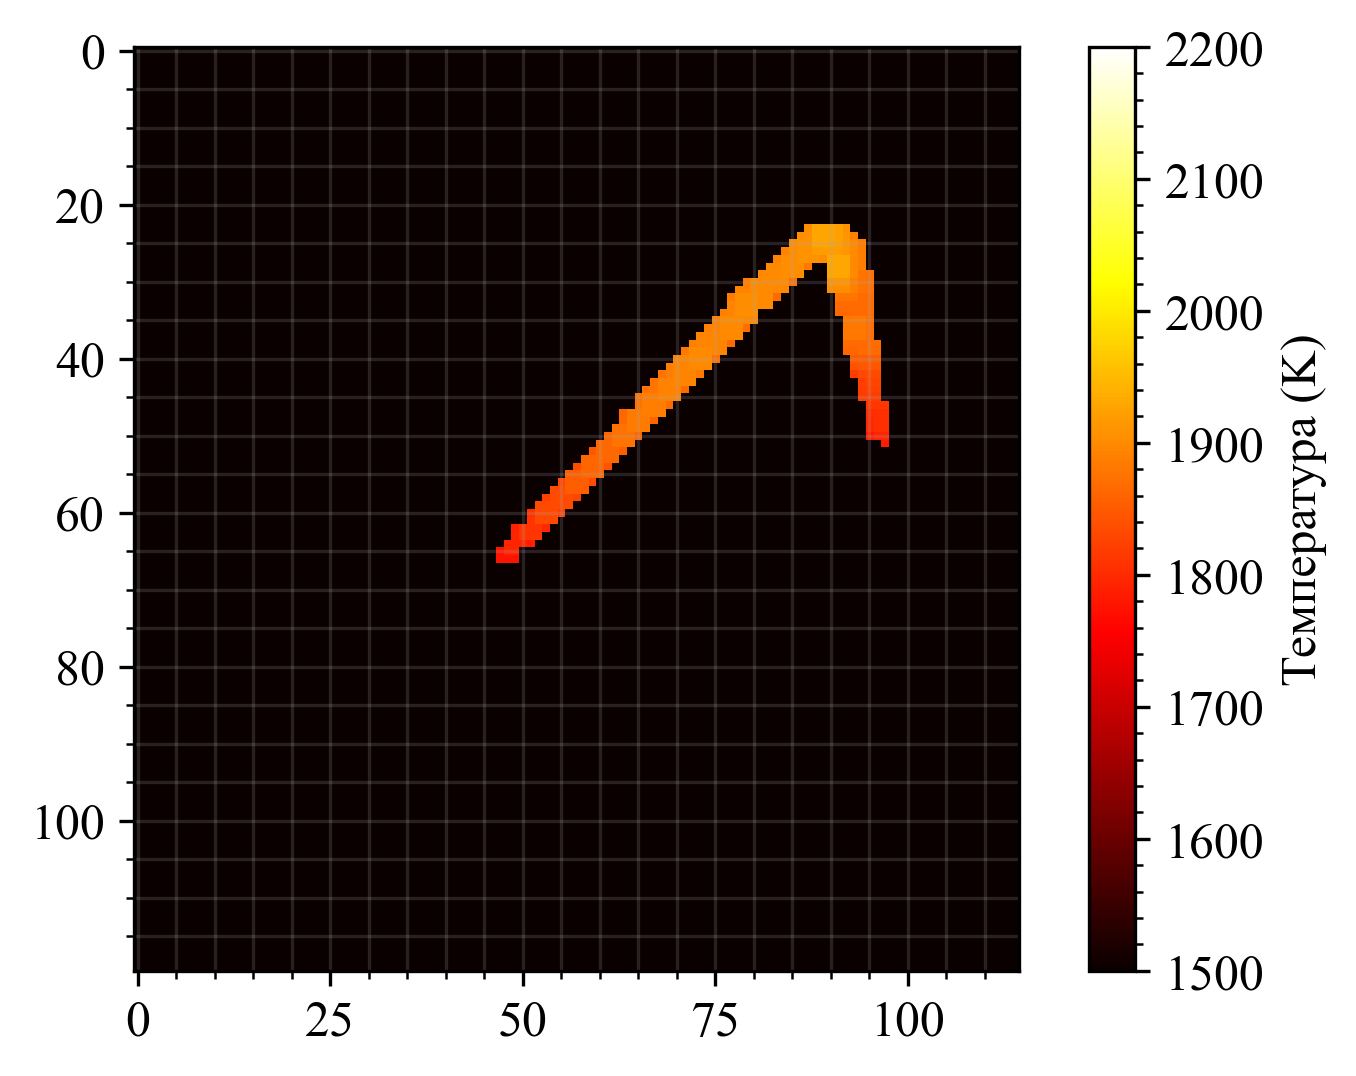

1750 mA


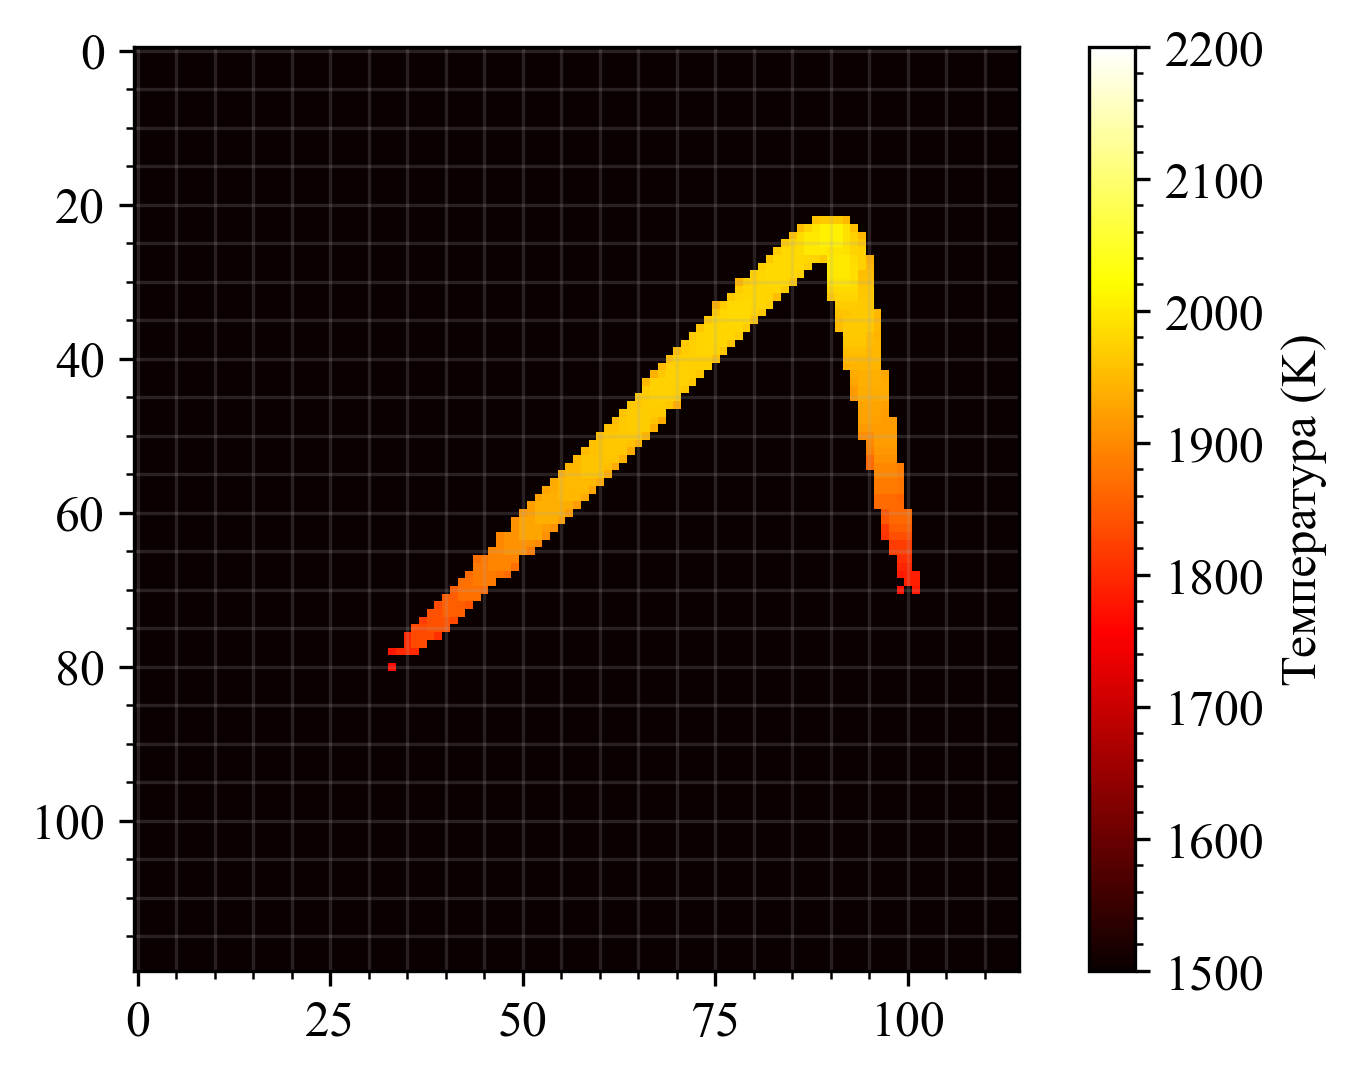

1800 mA


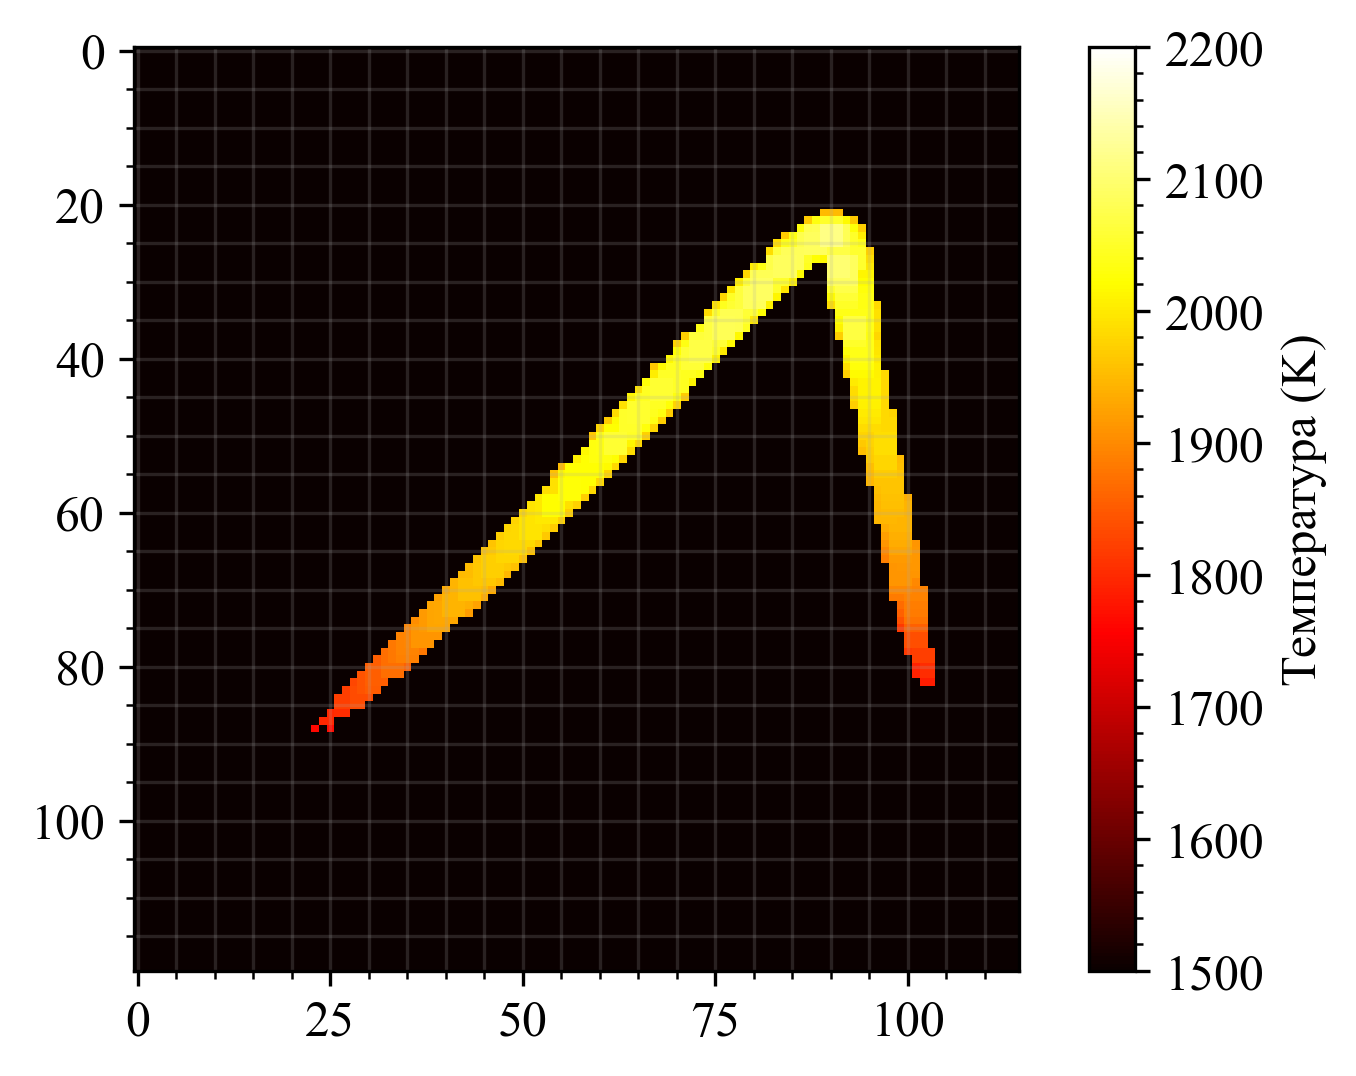

1850 mA


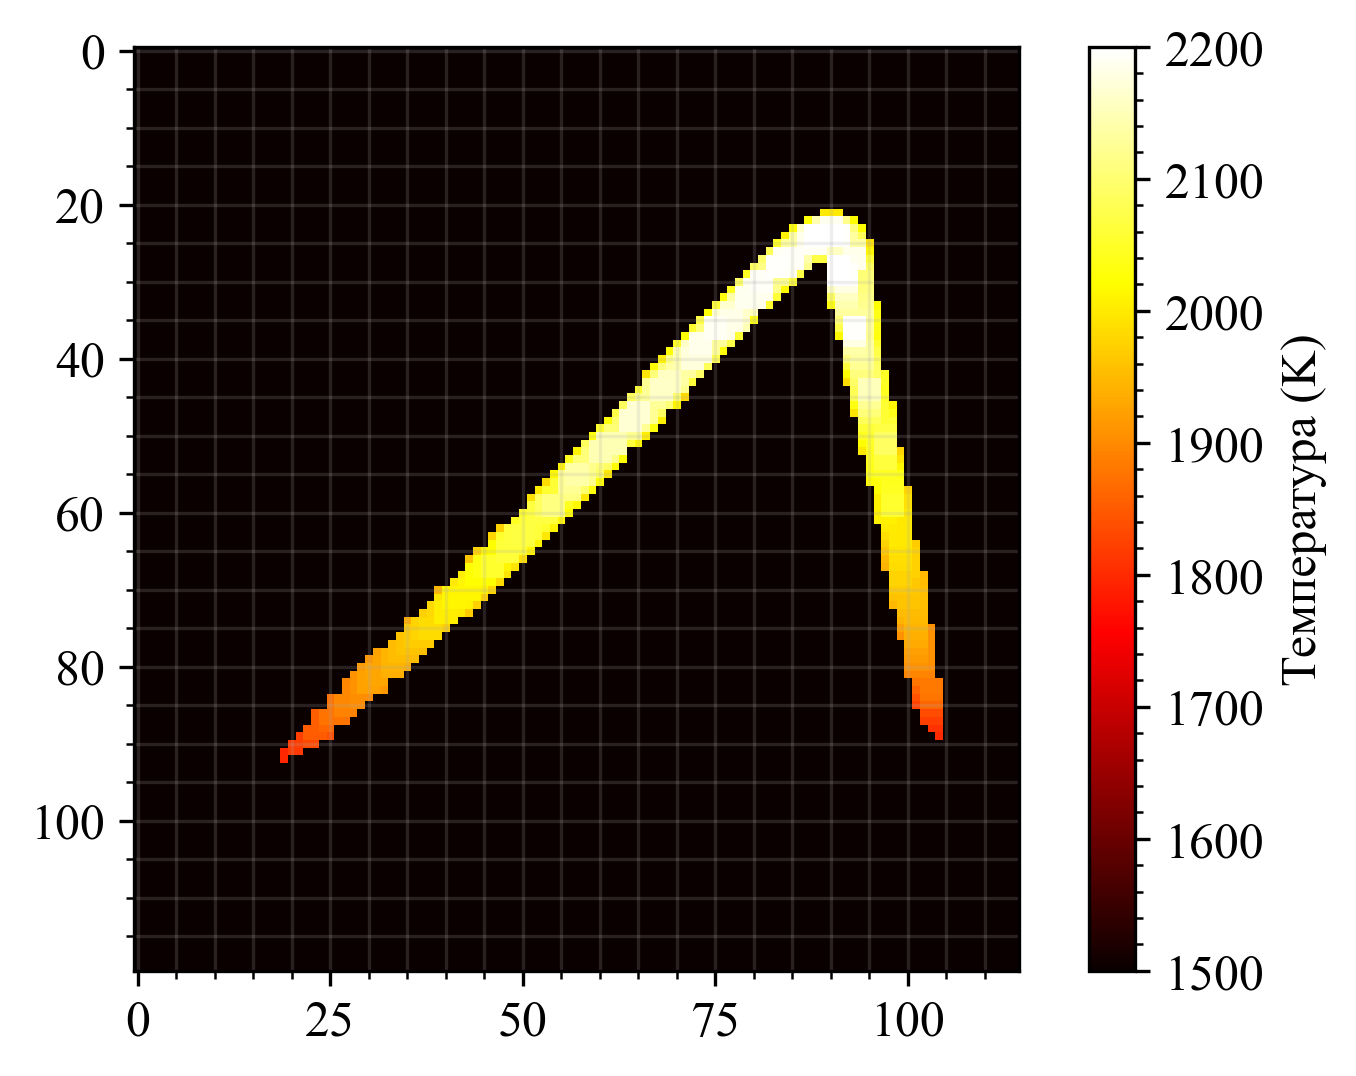

1900 mA


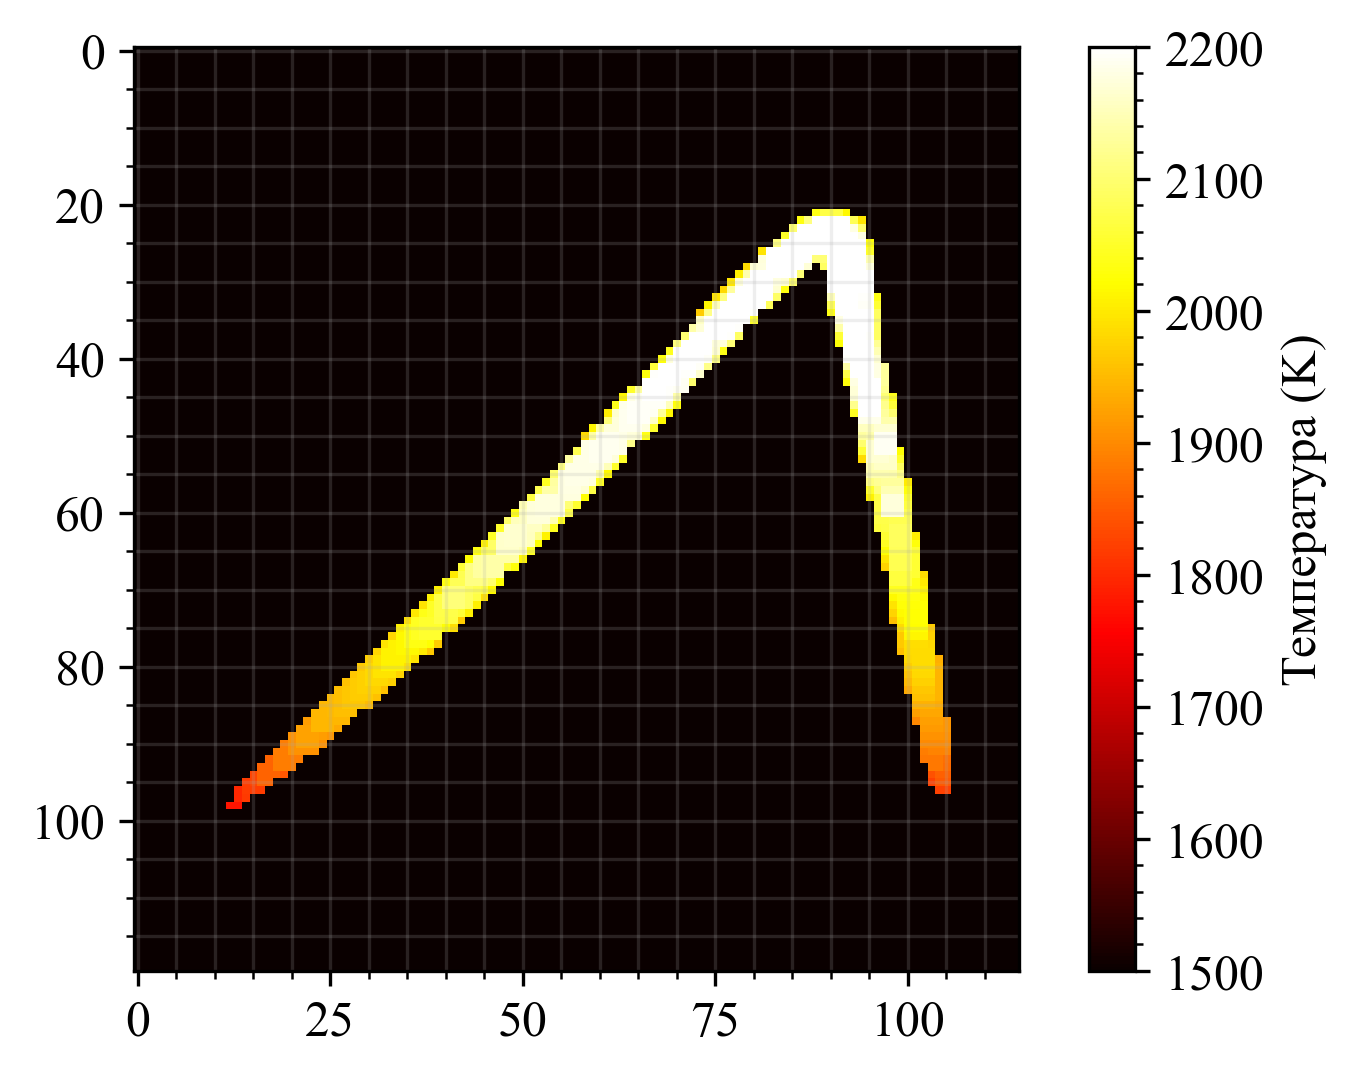

1950 mA


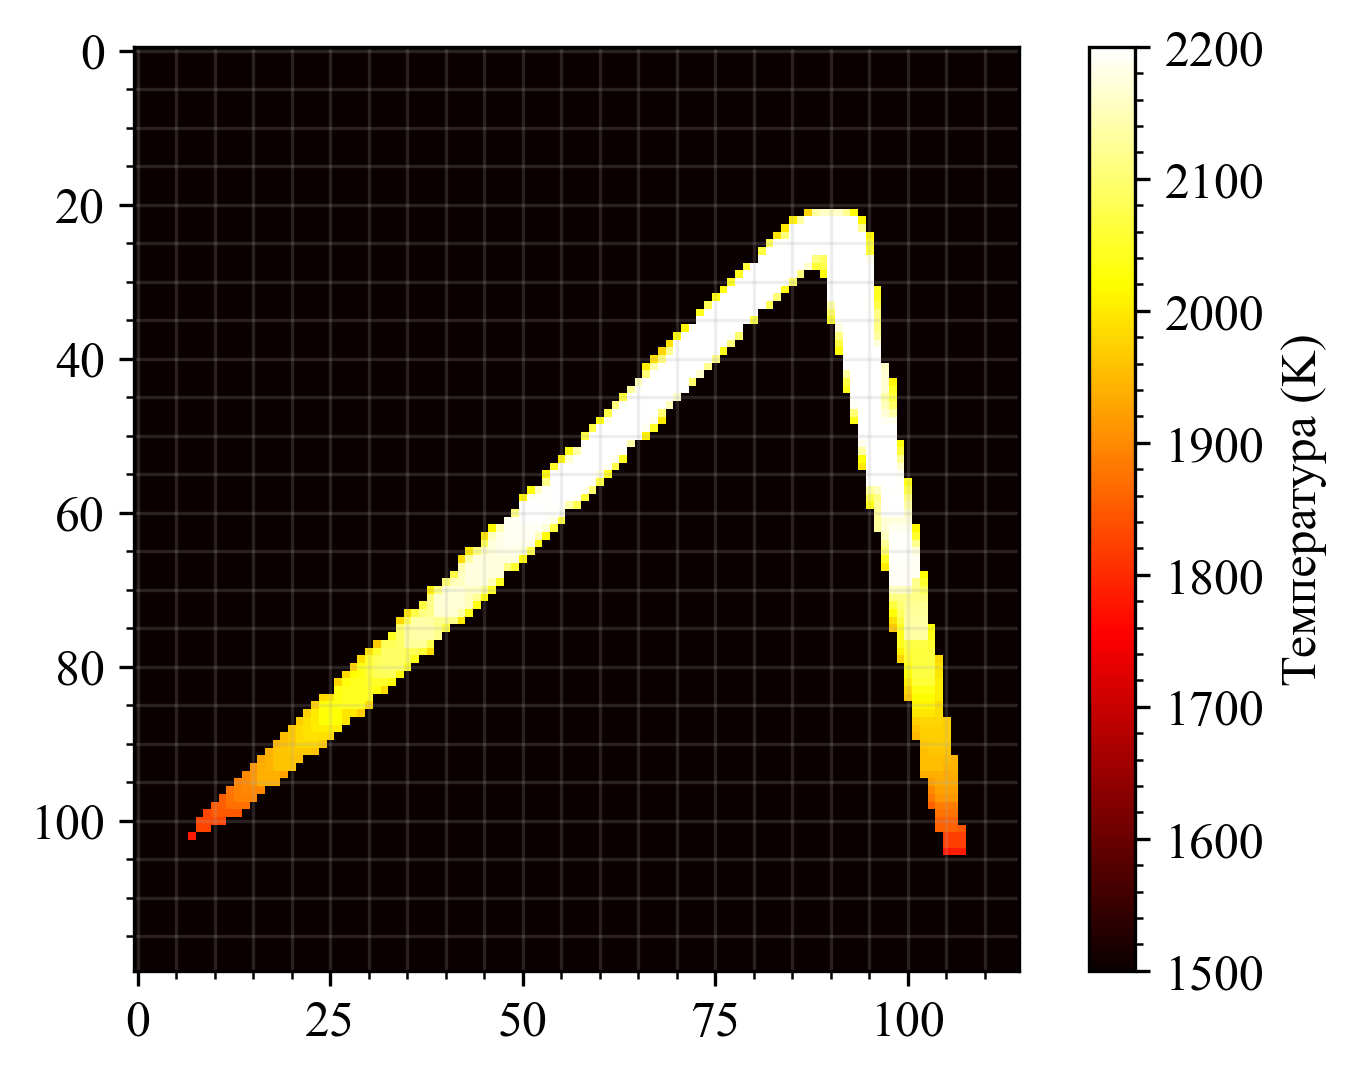

In [36]:
for i in [1700, 1750, 1800, 1850, 1900, 1950]:
    print(i, 'mA')
    _ = get_temperature_map(f'good_cathode_11+7/good_{i}_11_7_roi.png', T_bri_11_7, plot=True)


1500 30


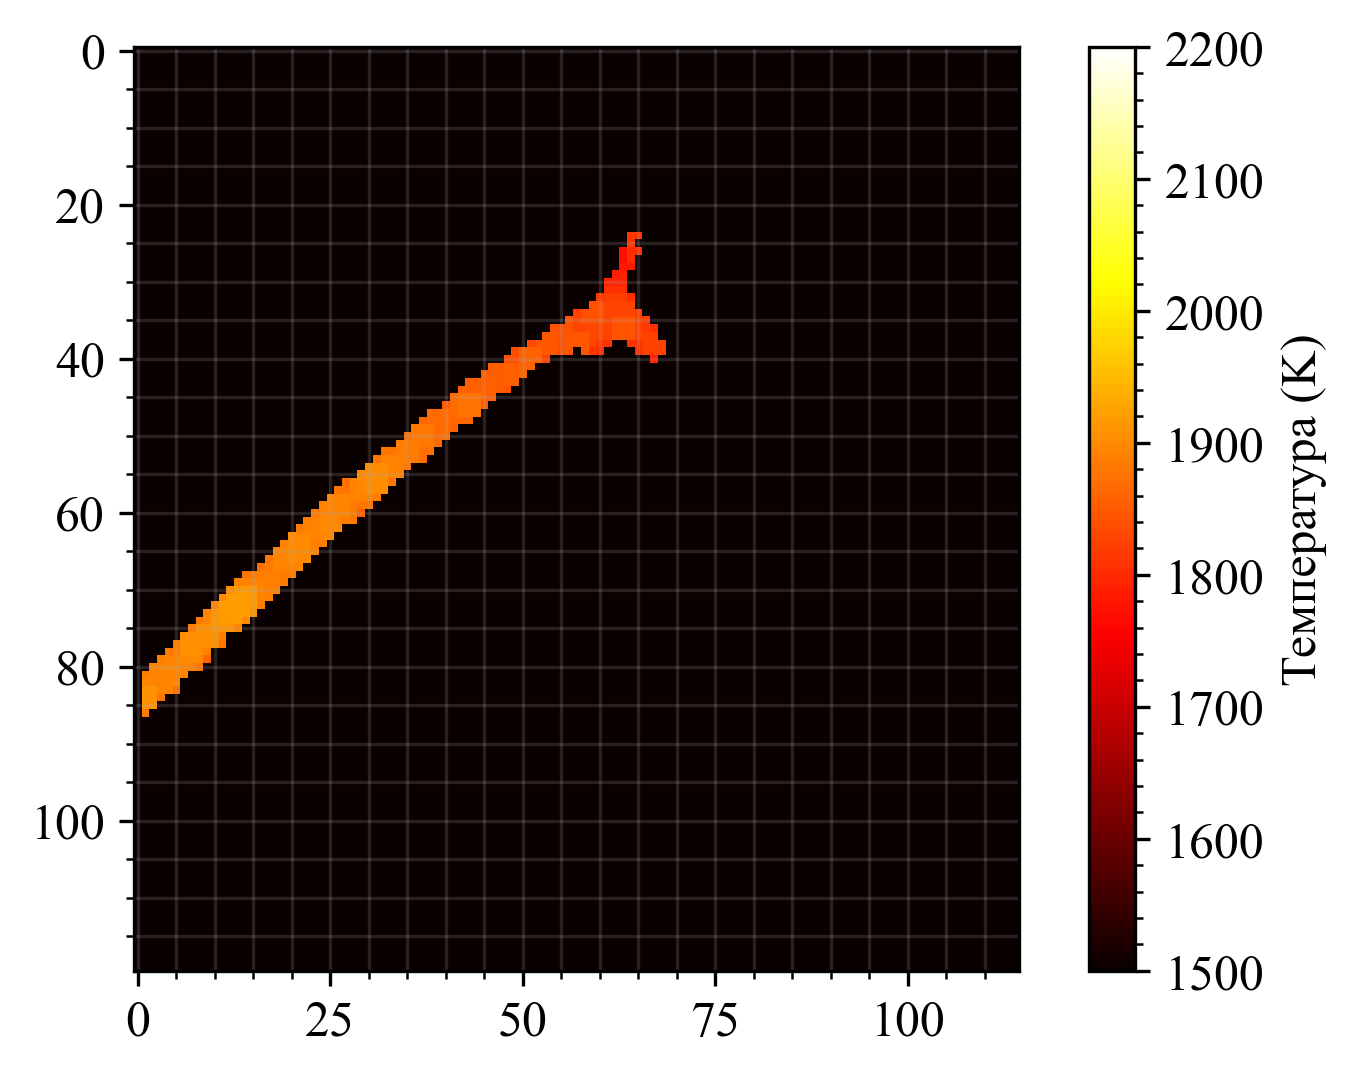

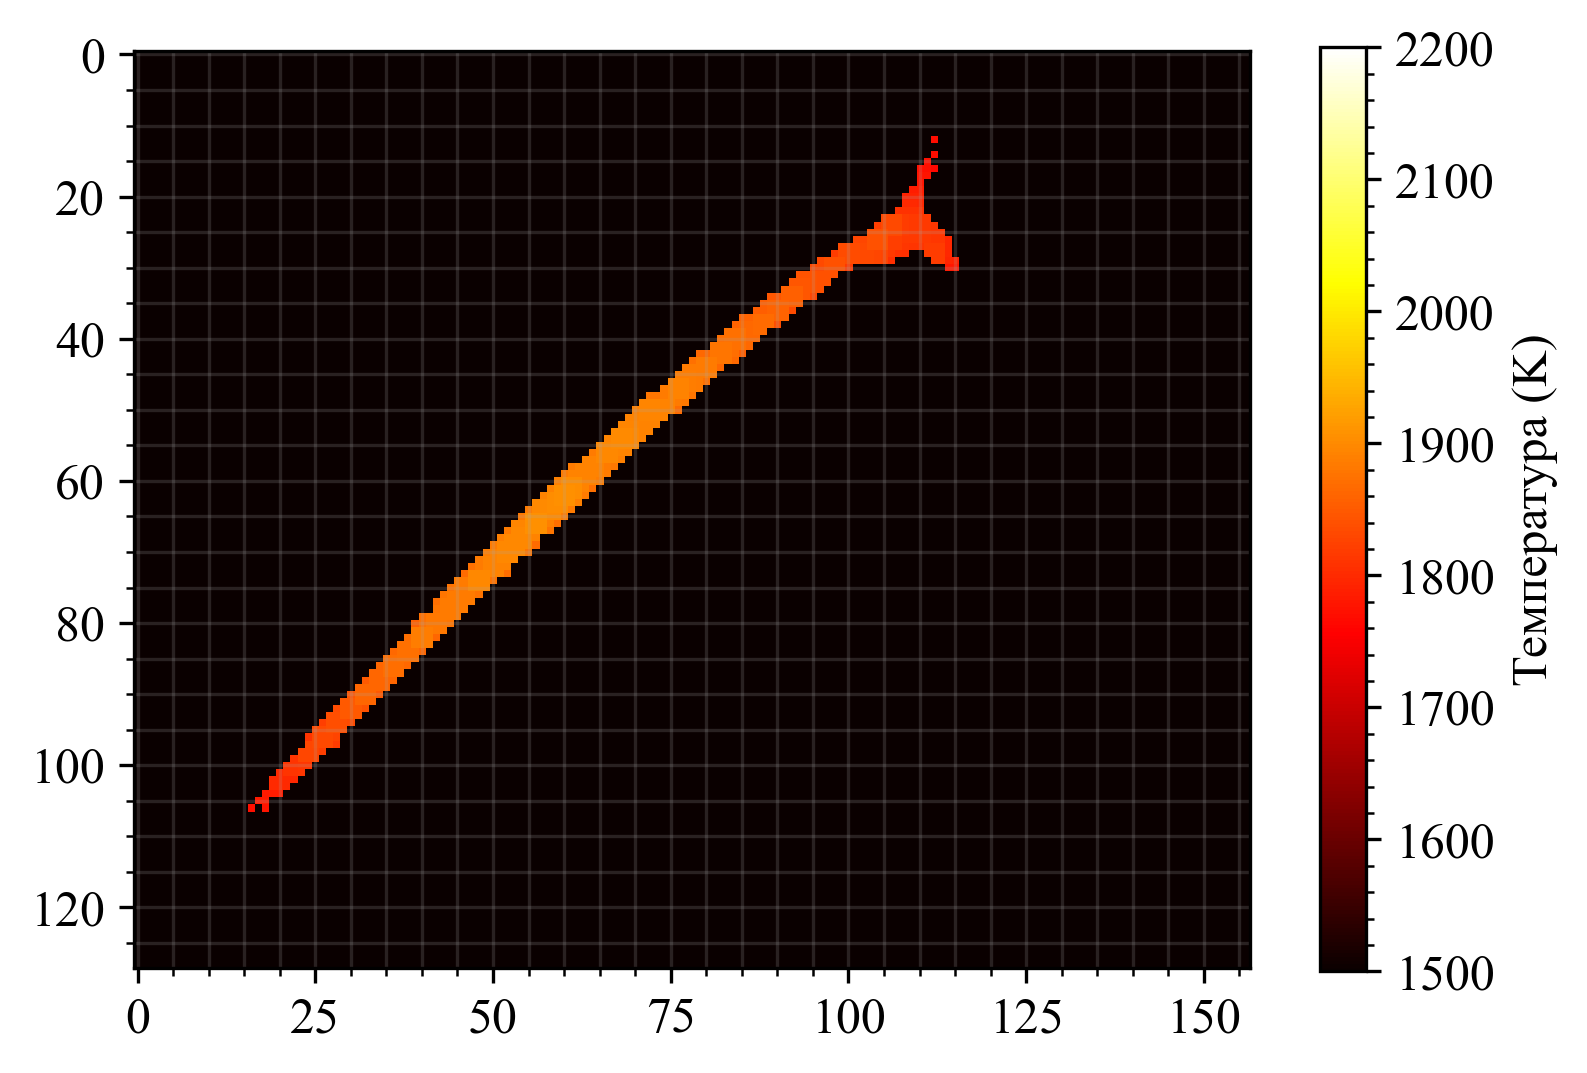

1500 60


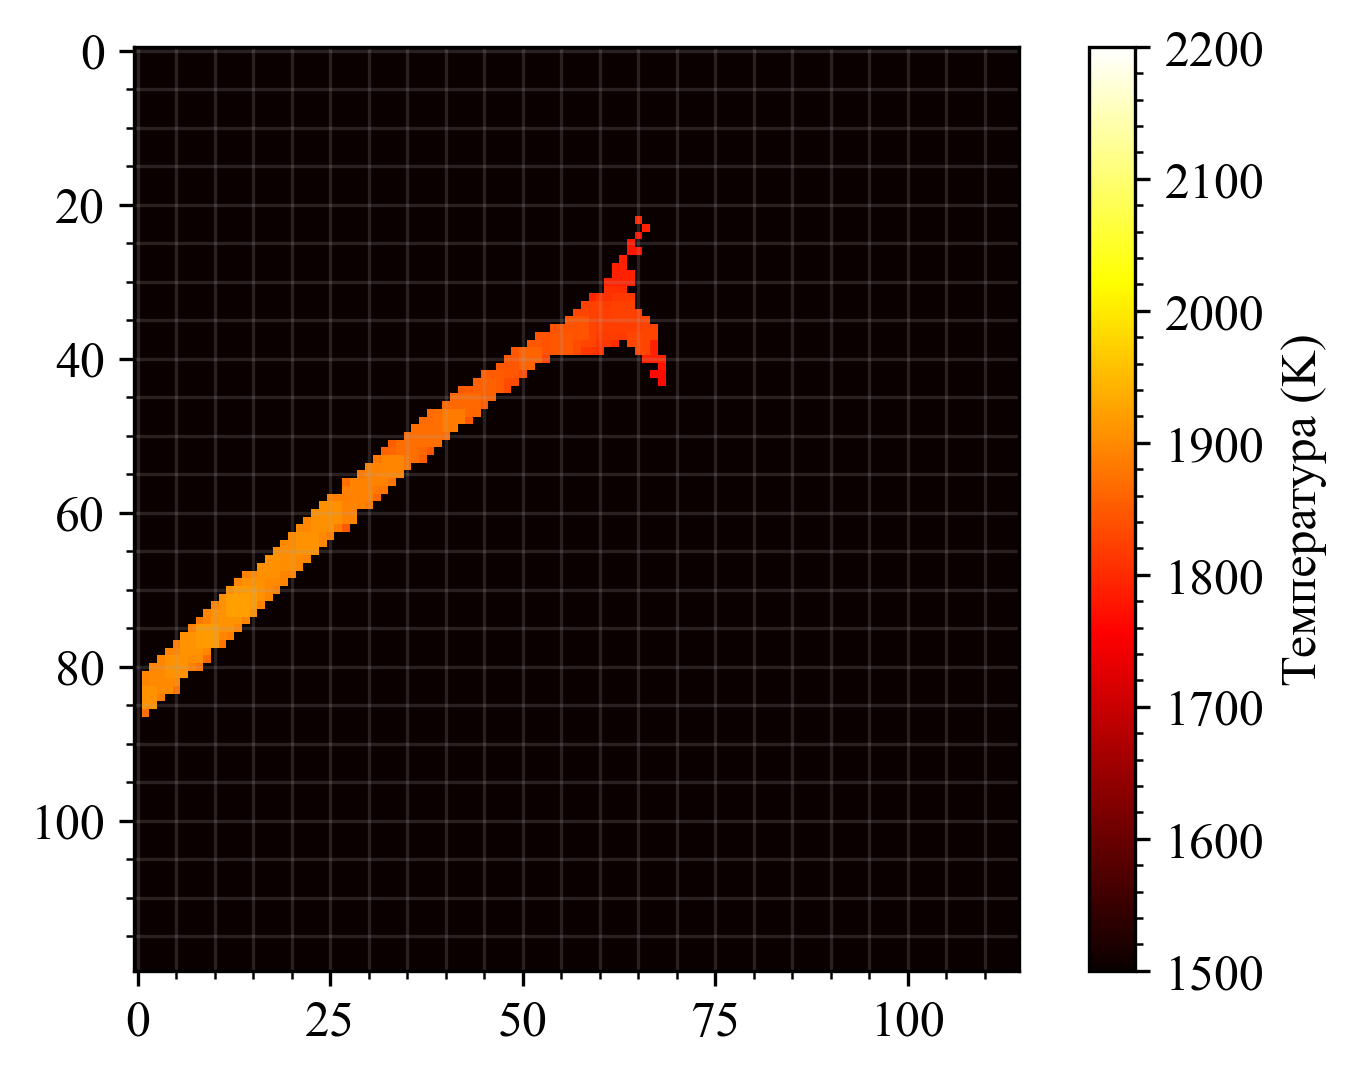

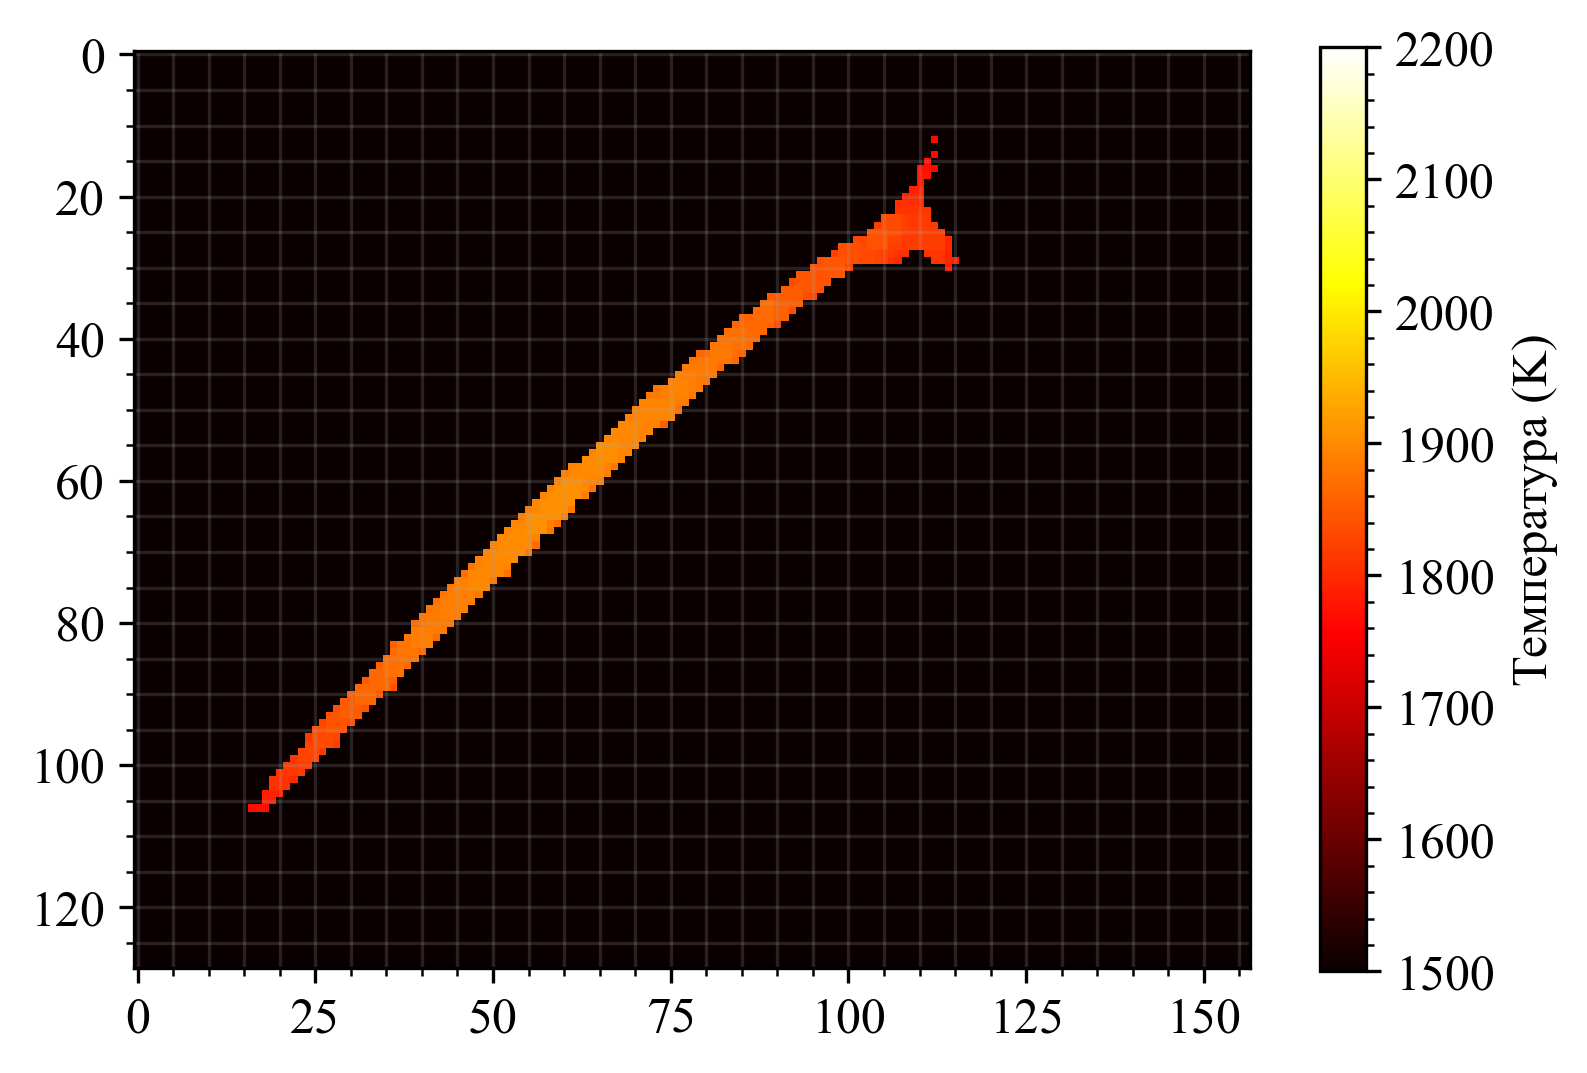

1500 120


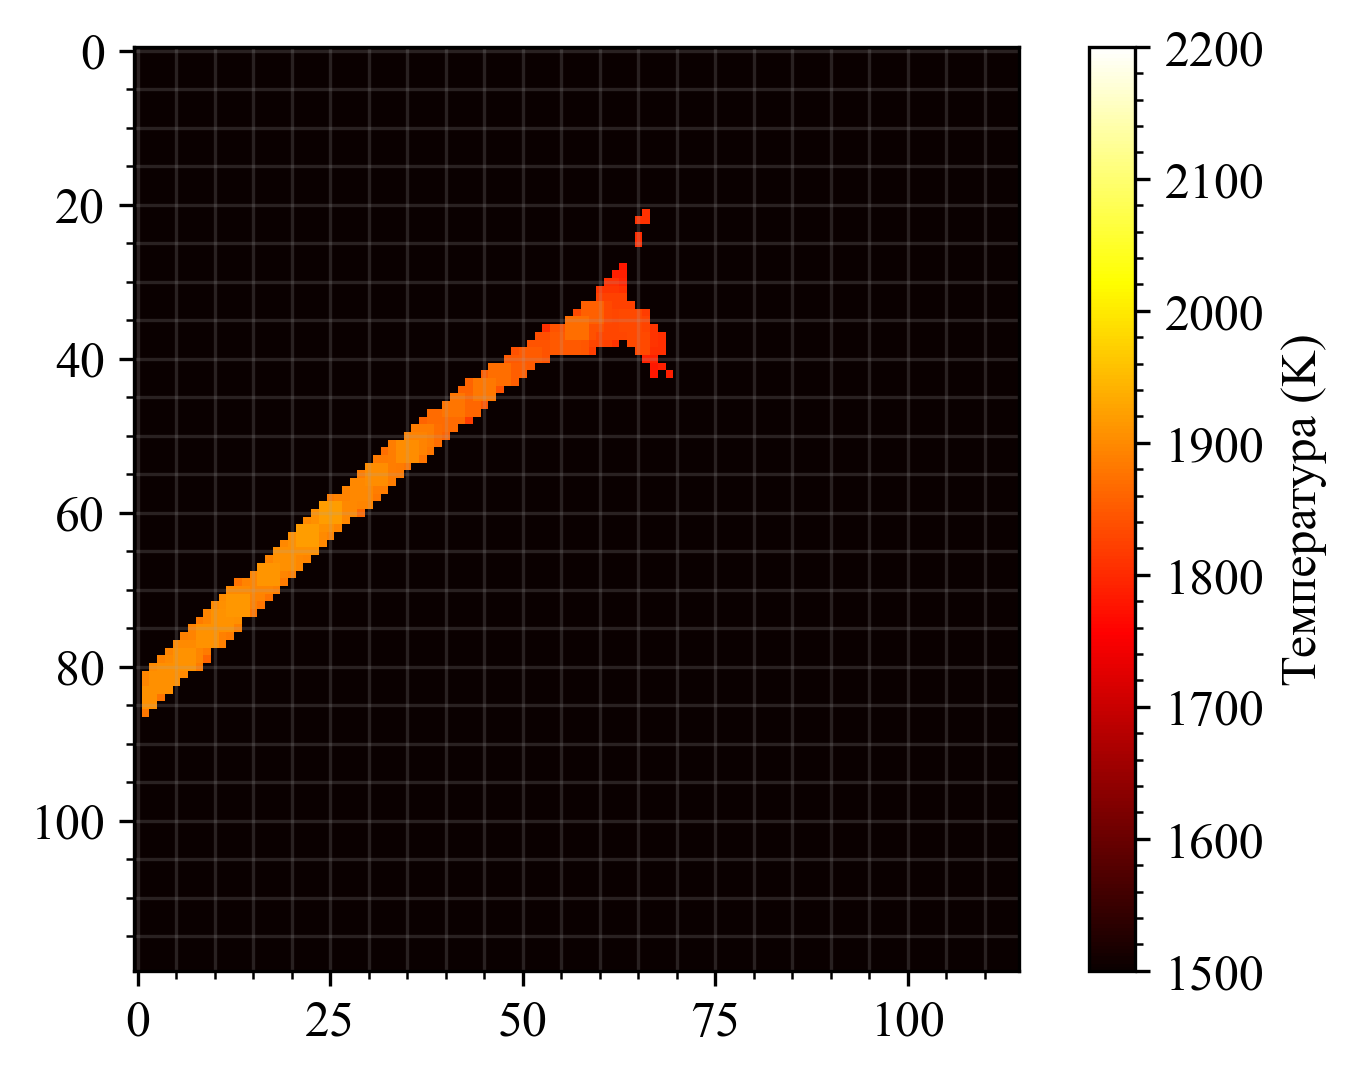

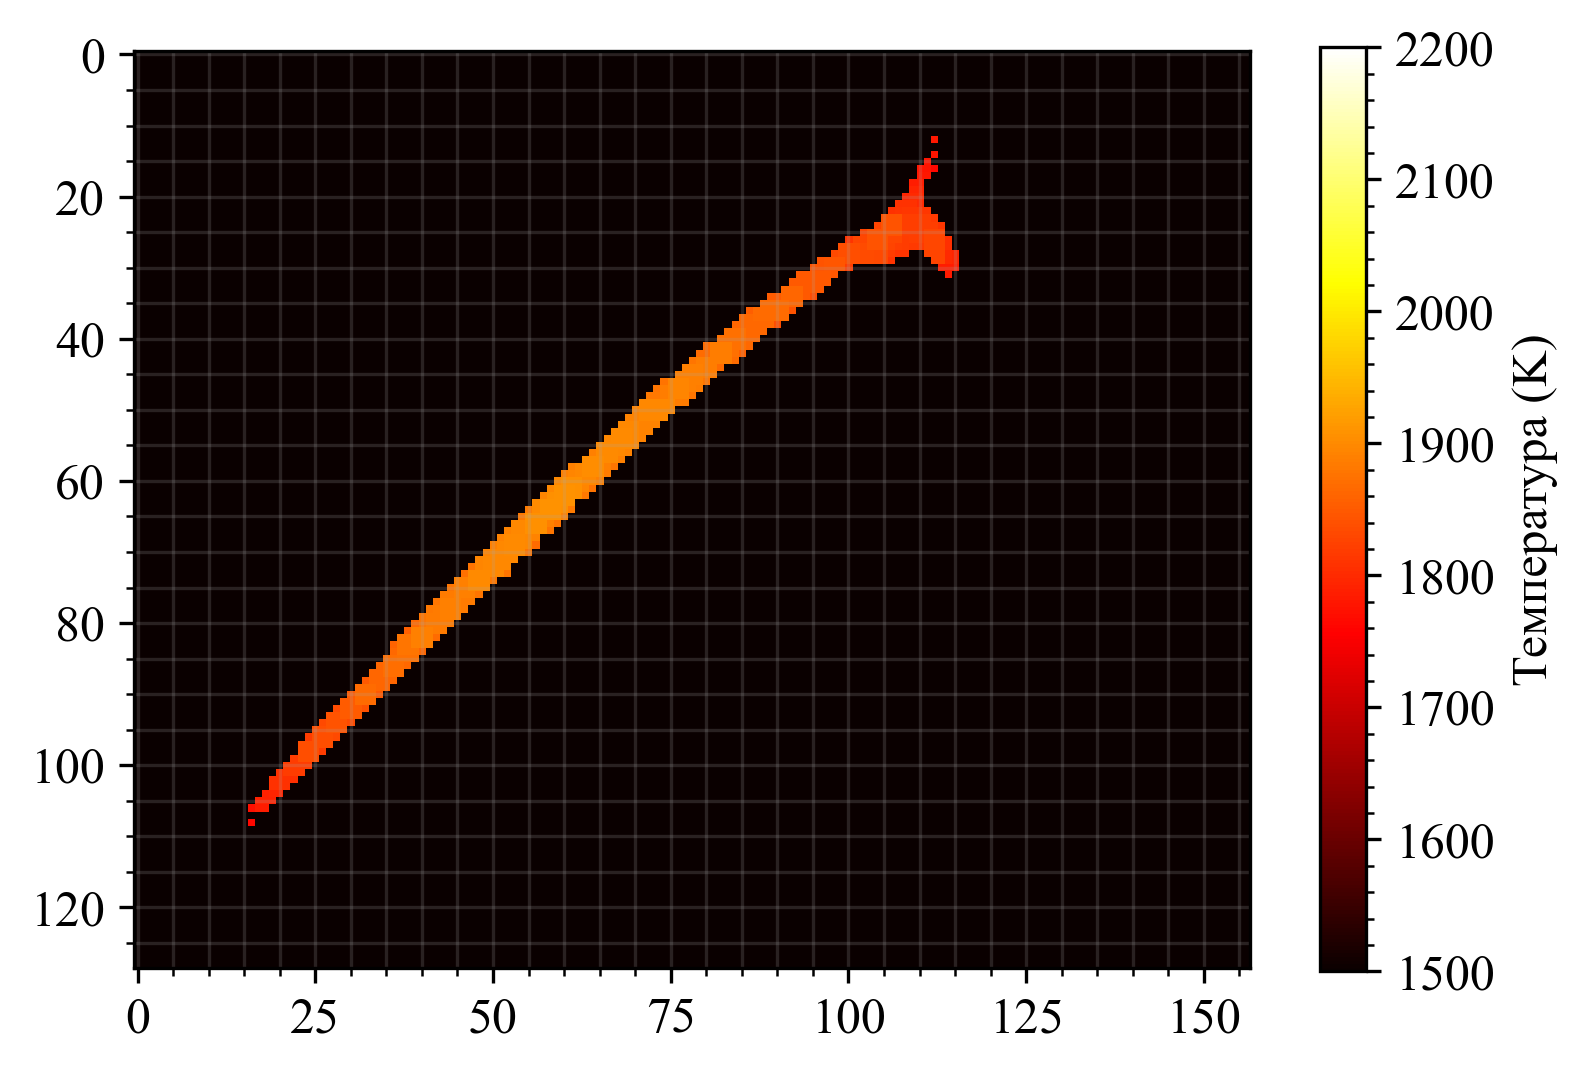

1600 30


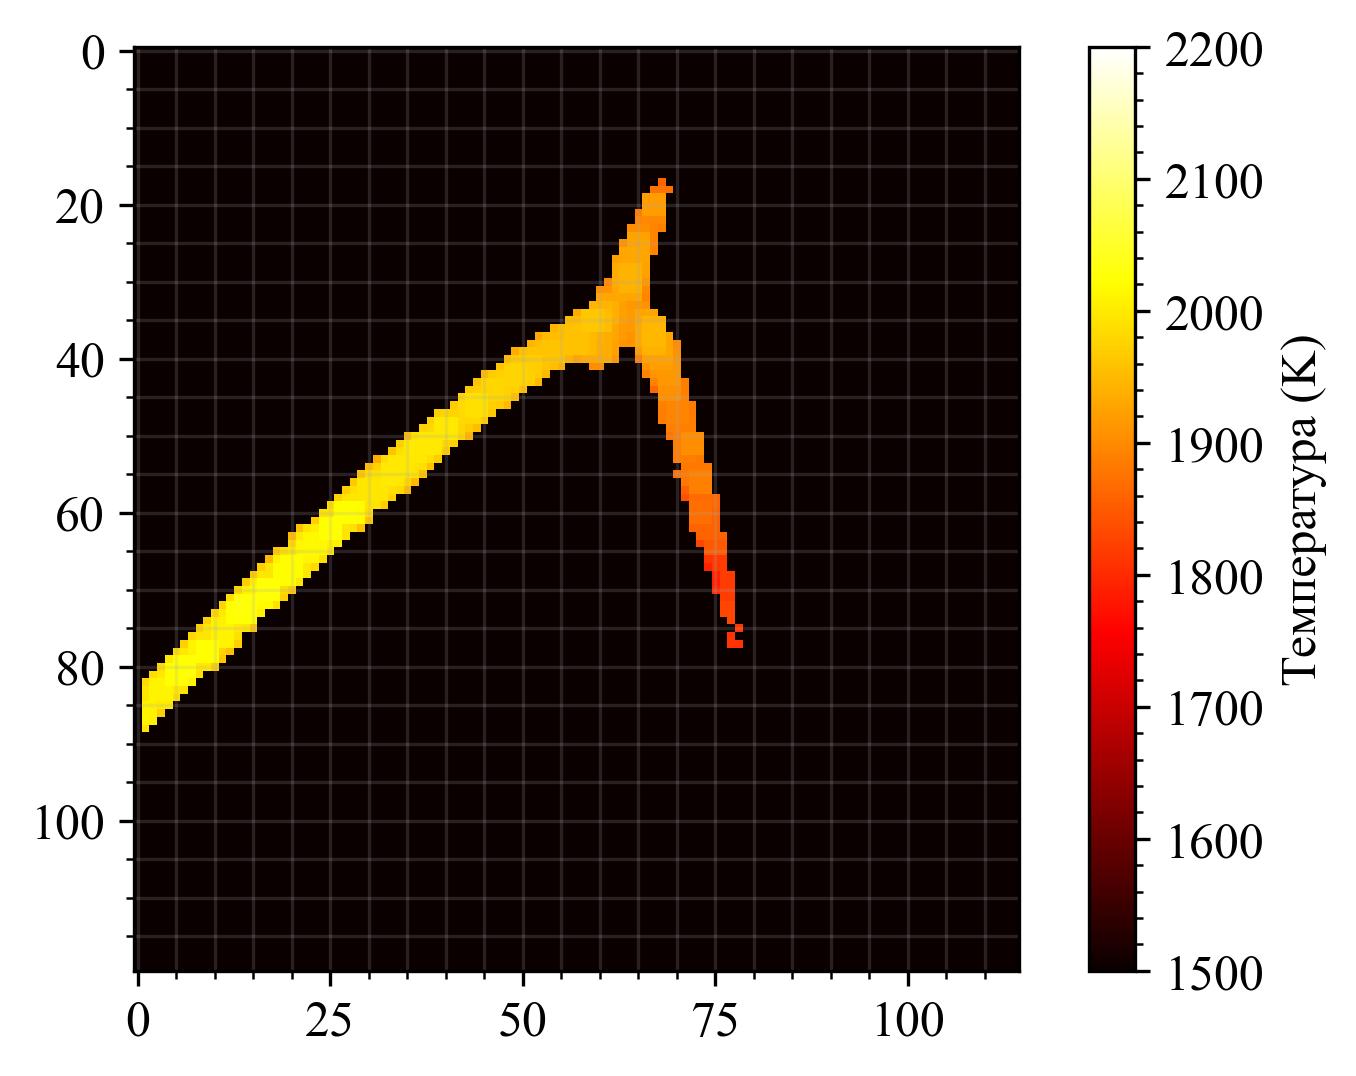

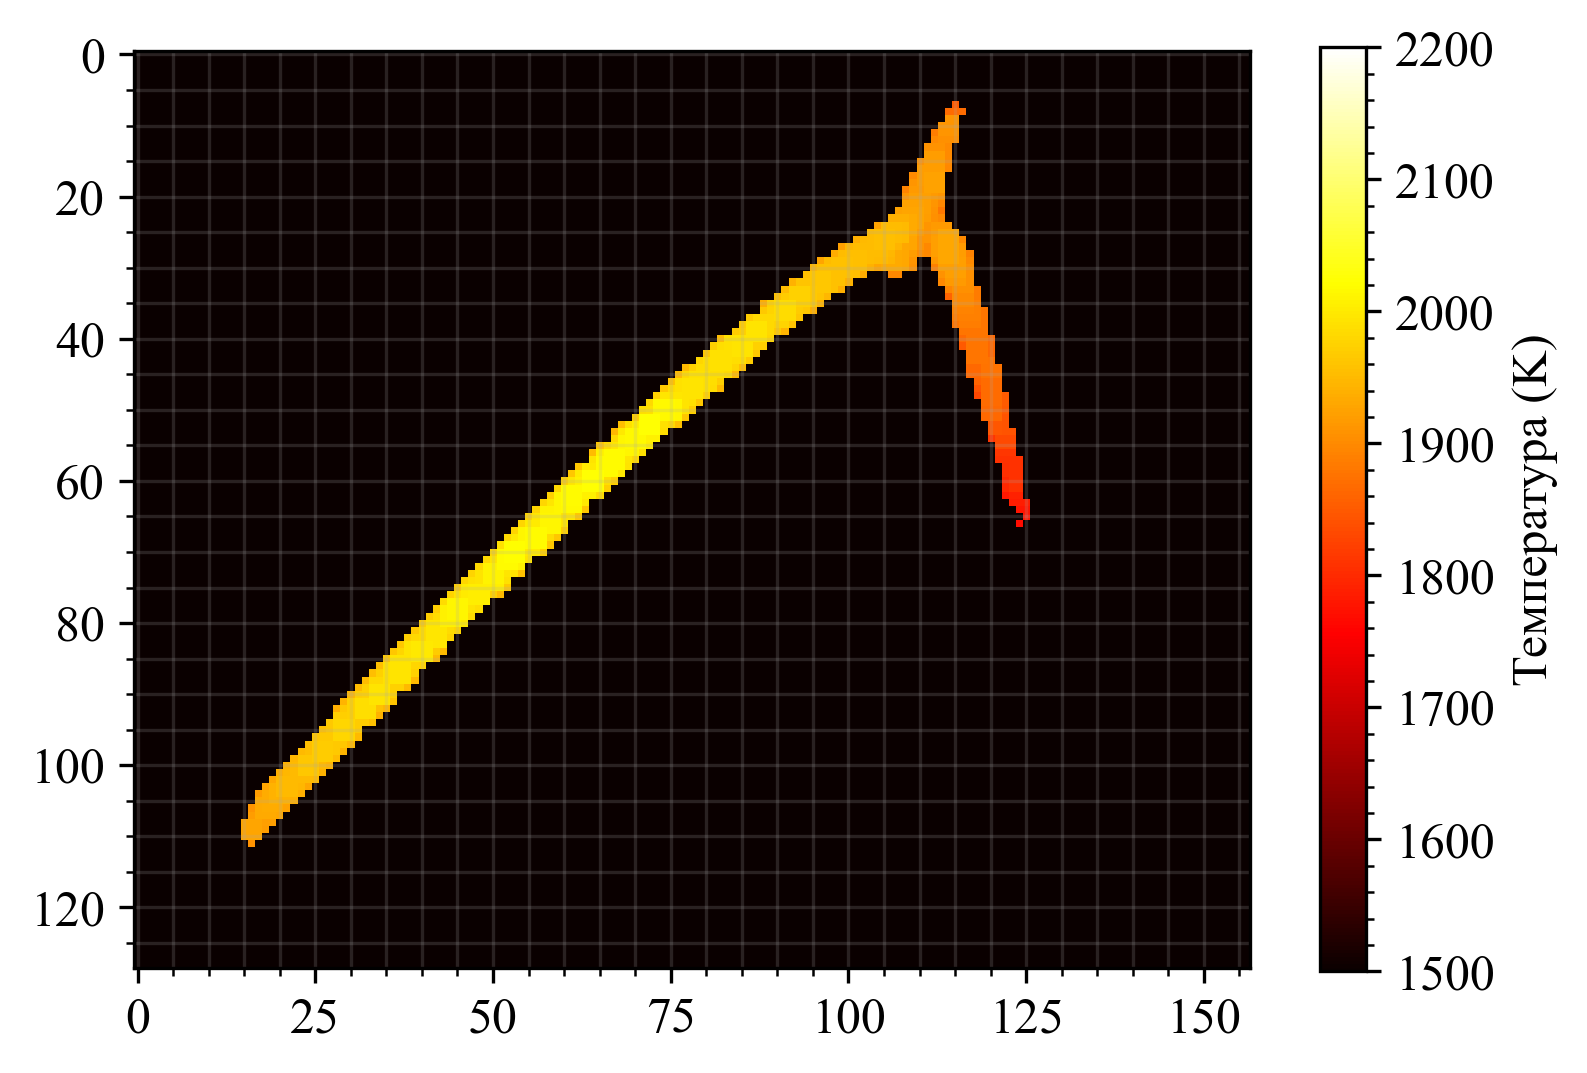

1600 60


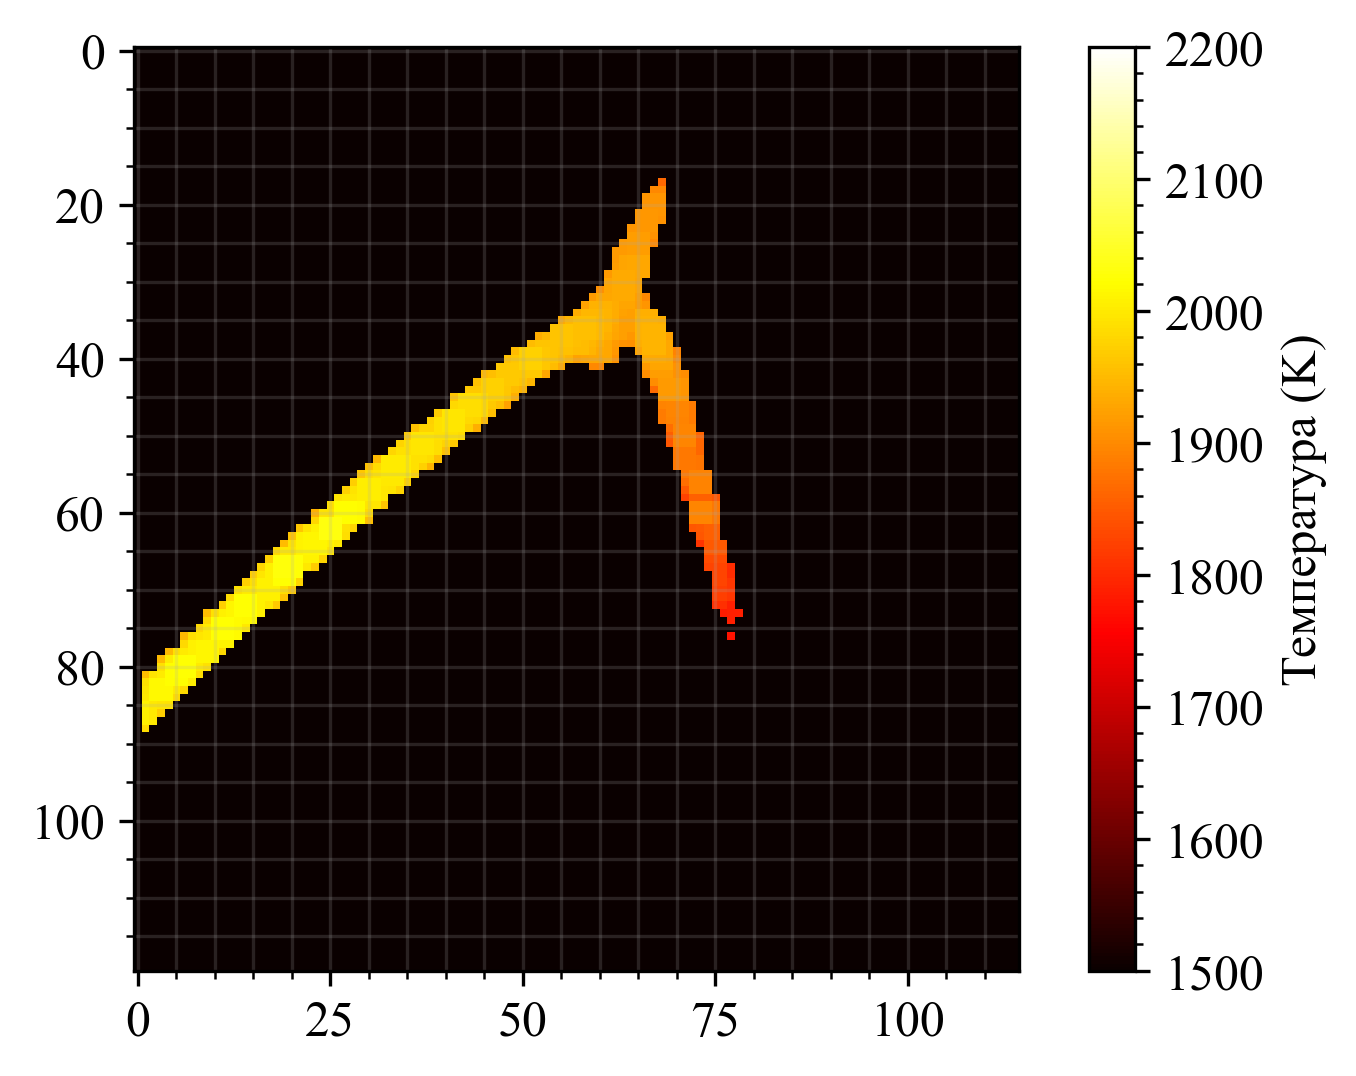

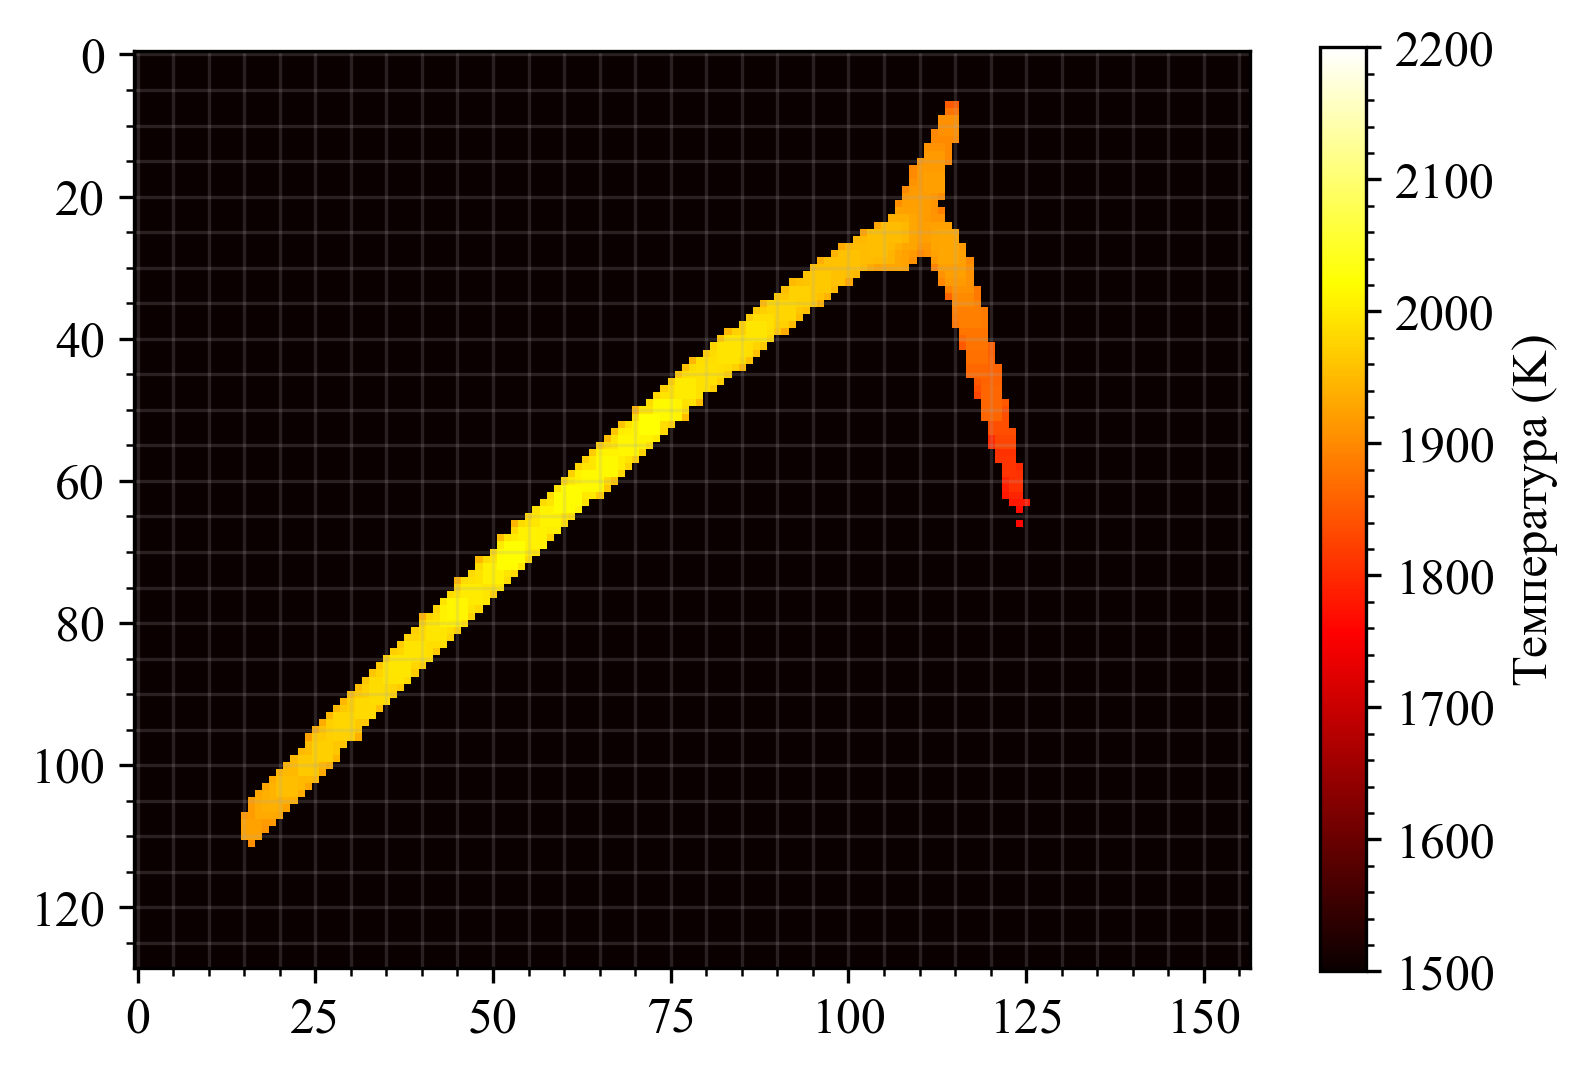

1600 120


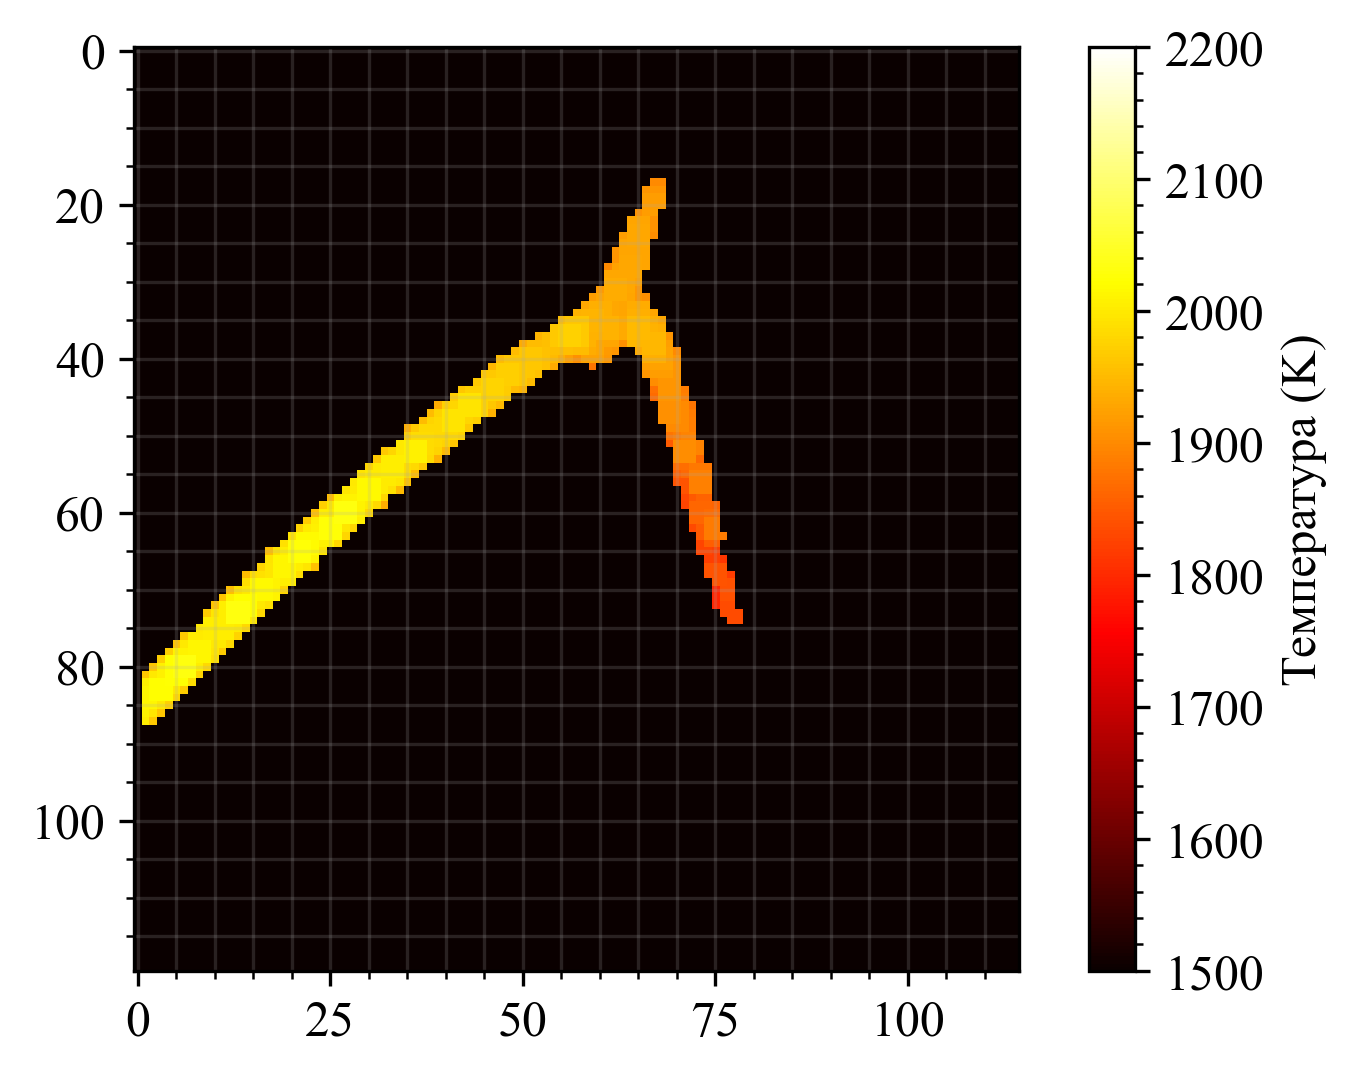

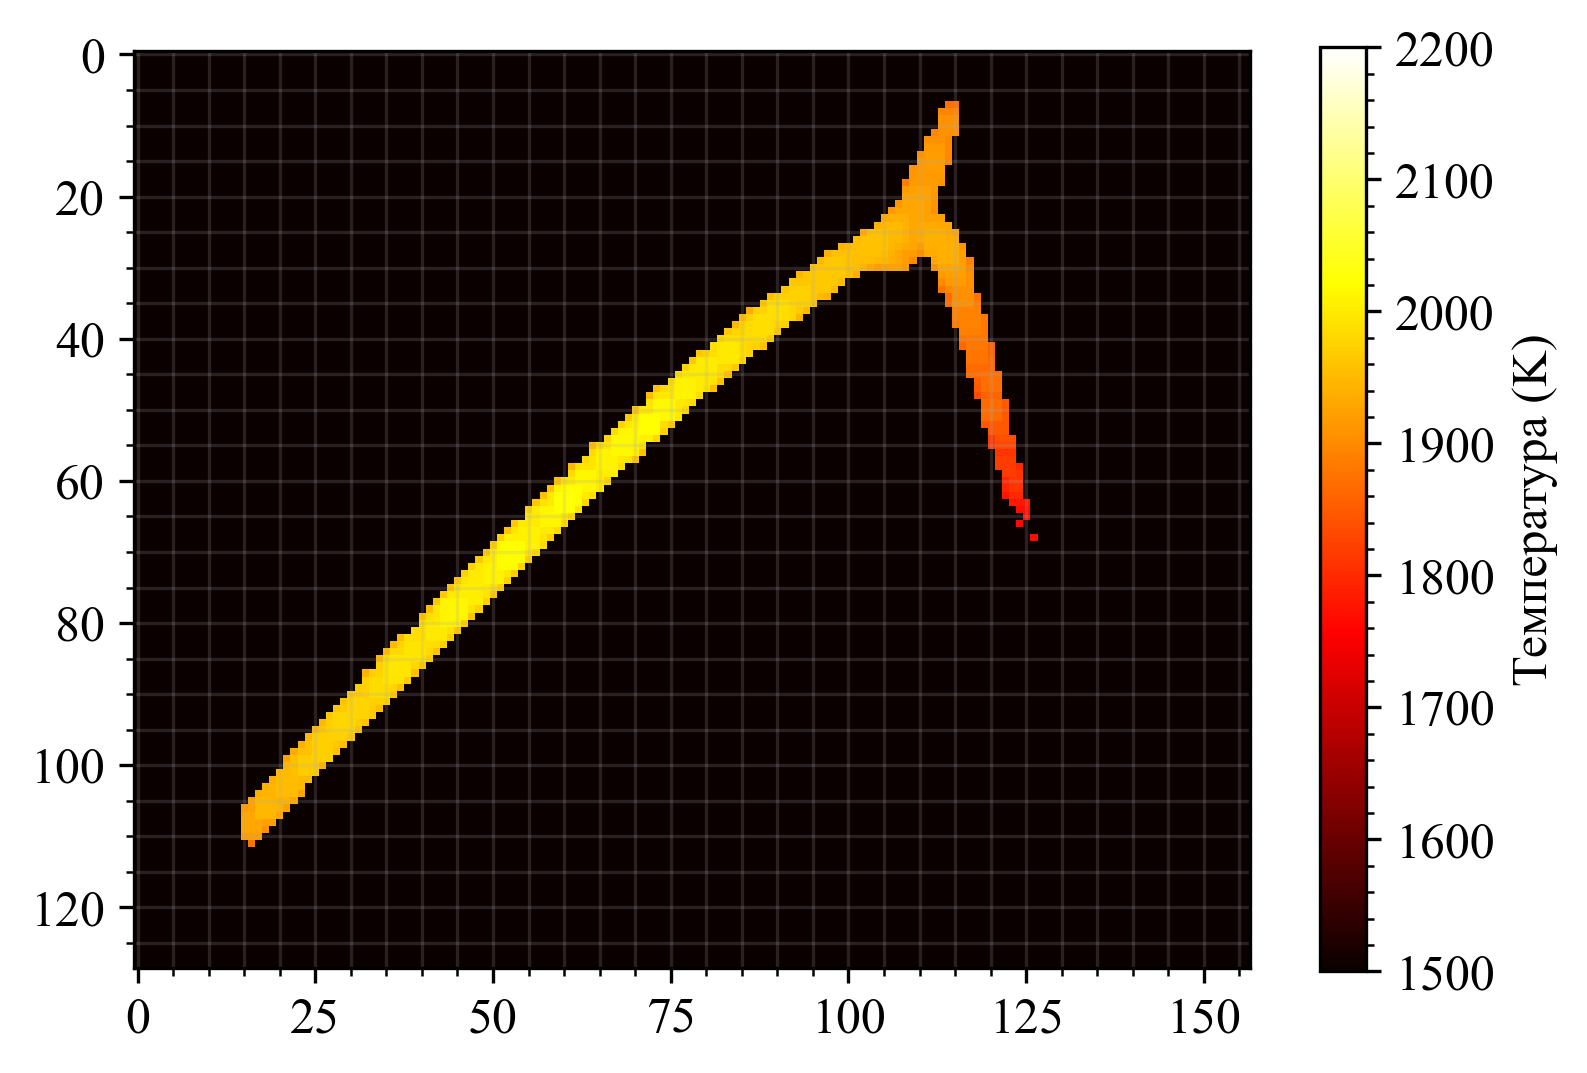

1700 30


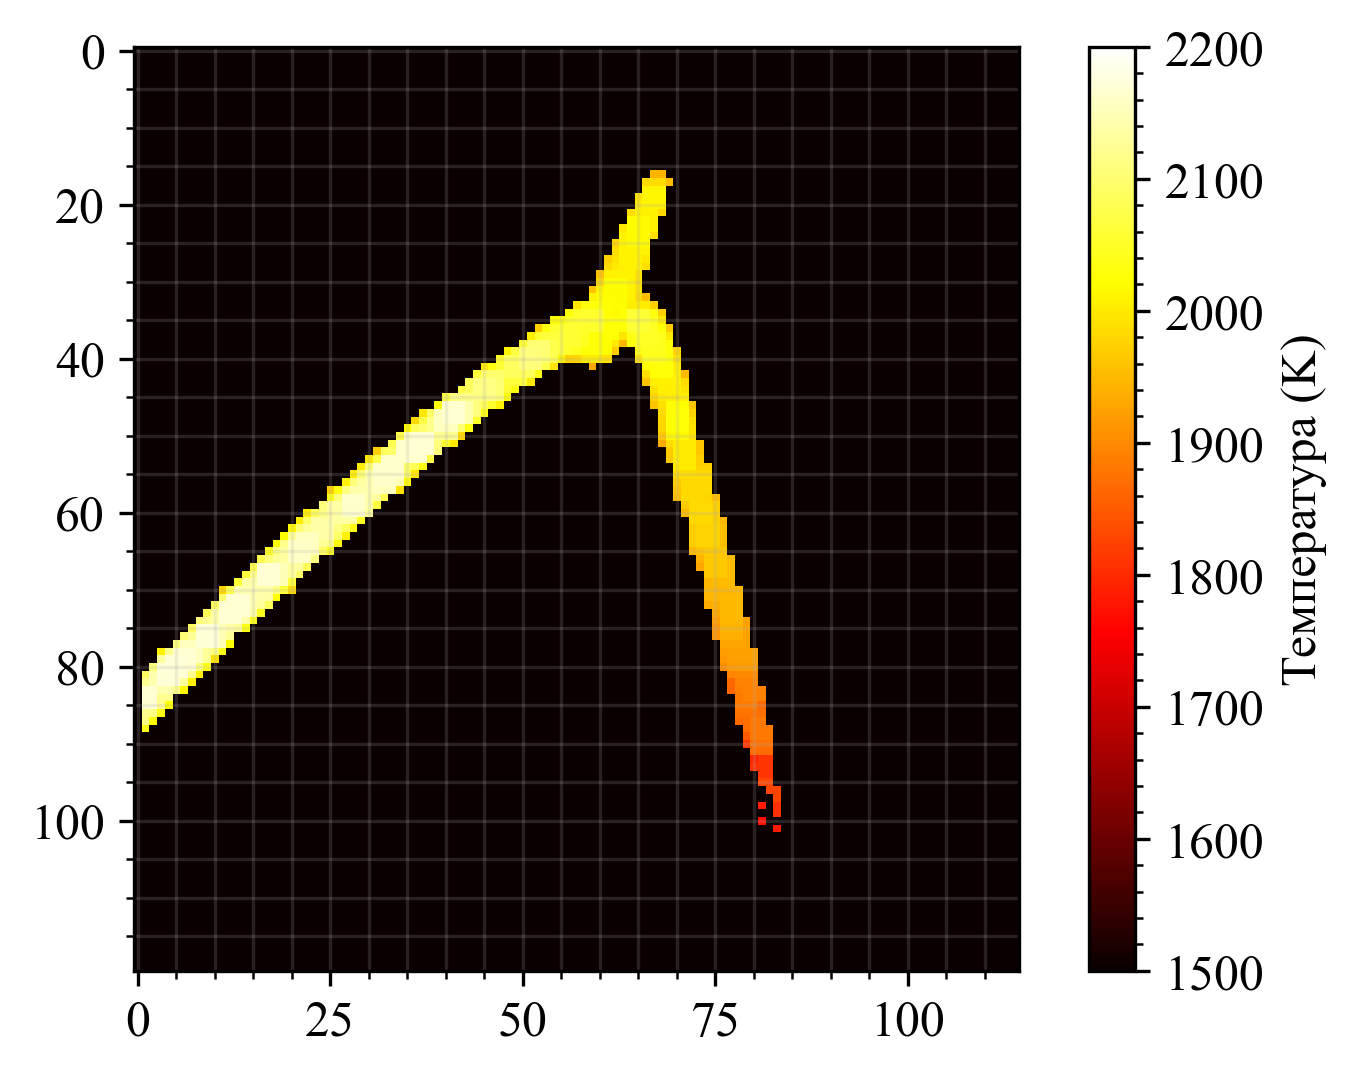

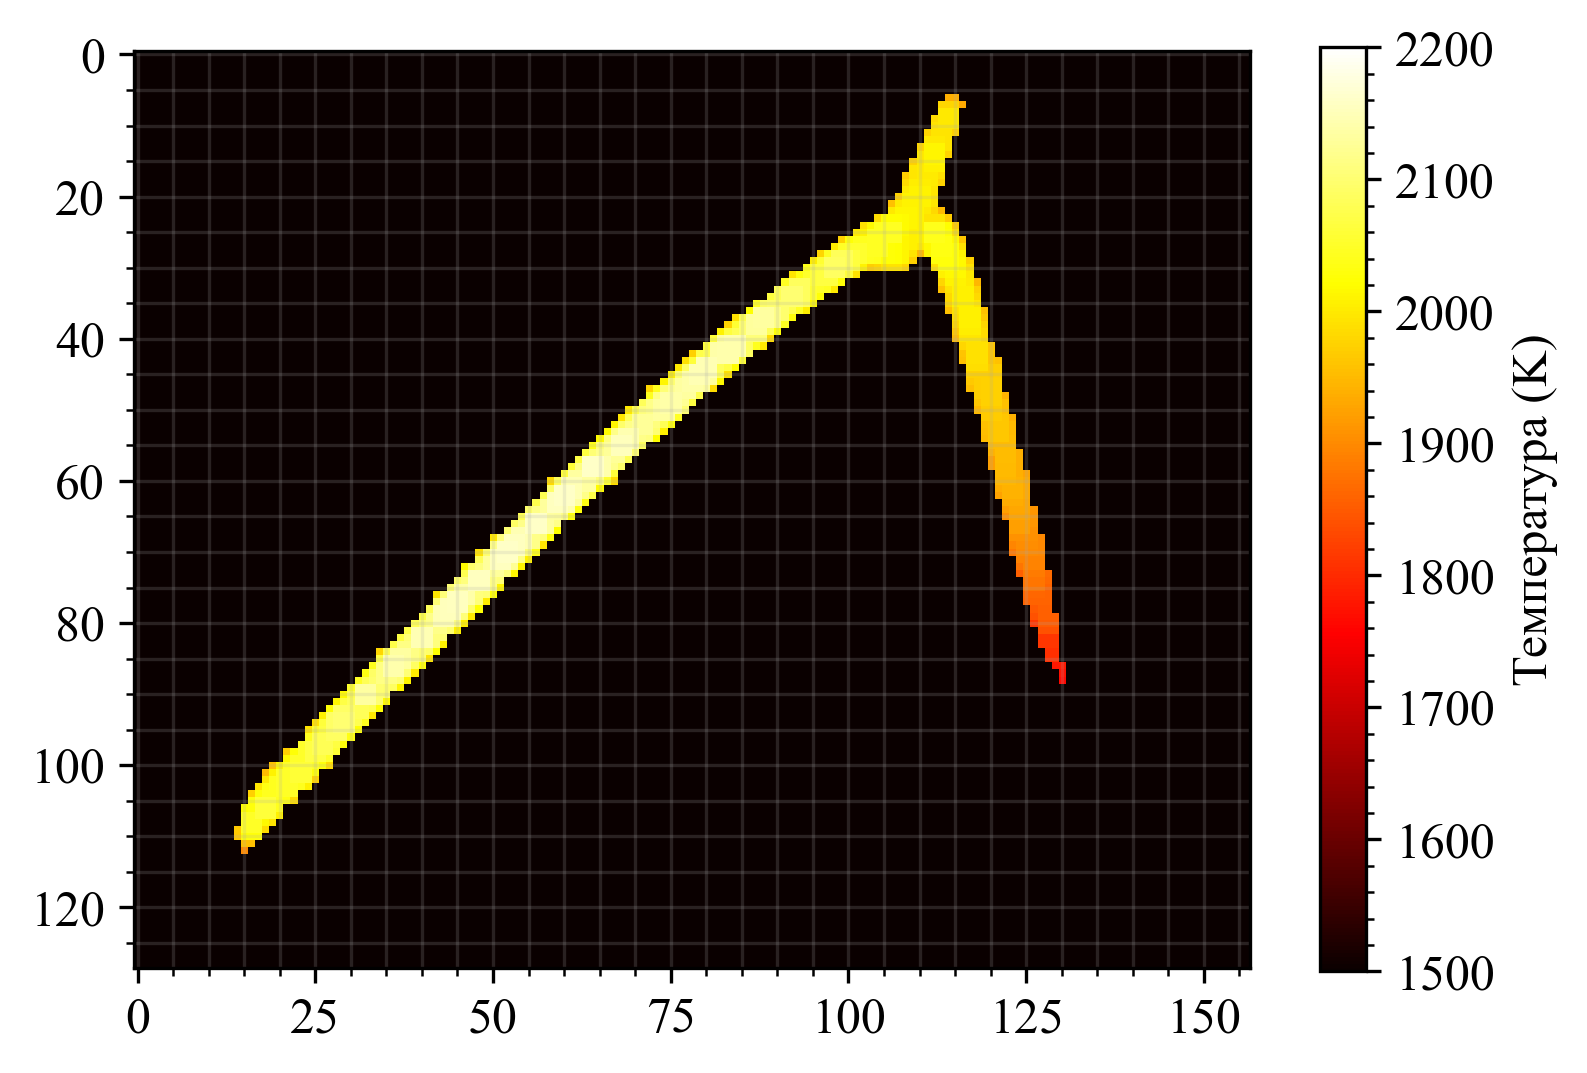

1700 60


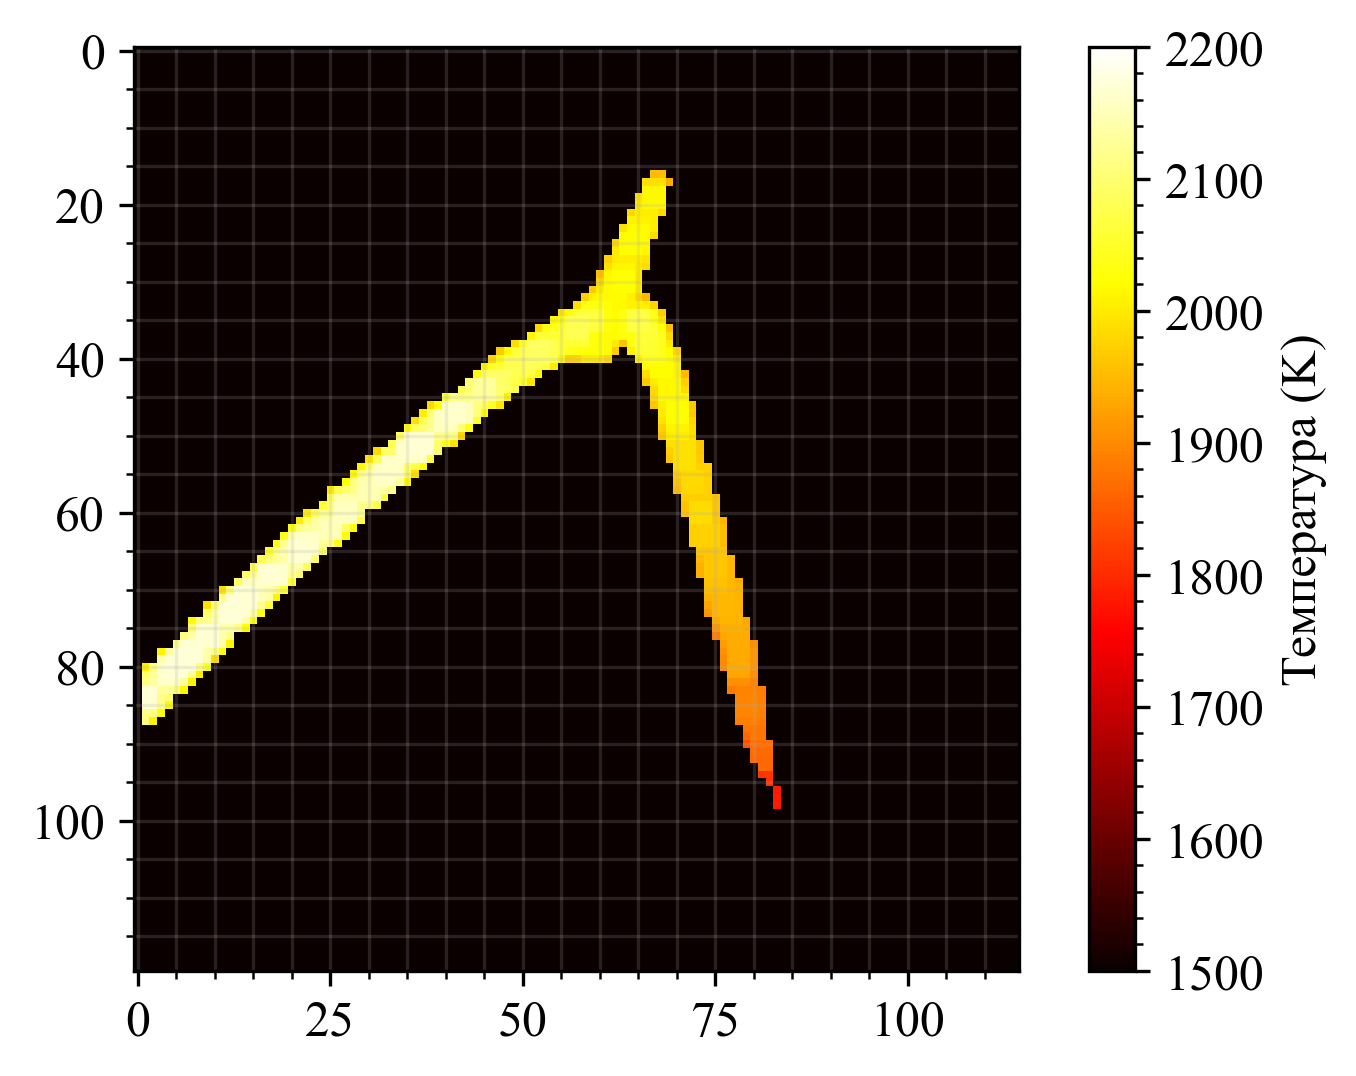

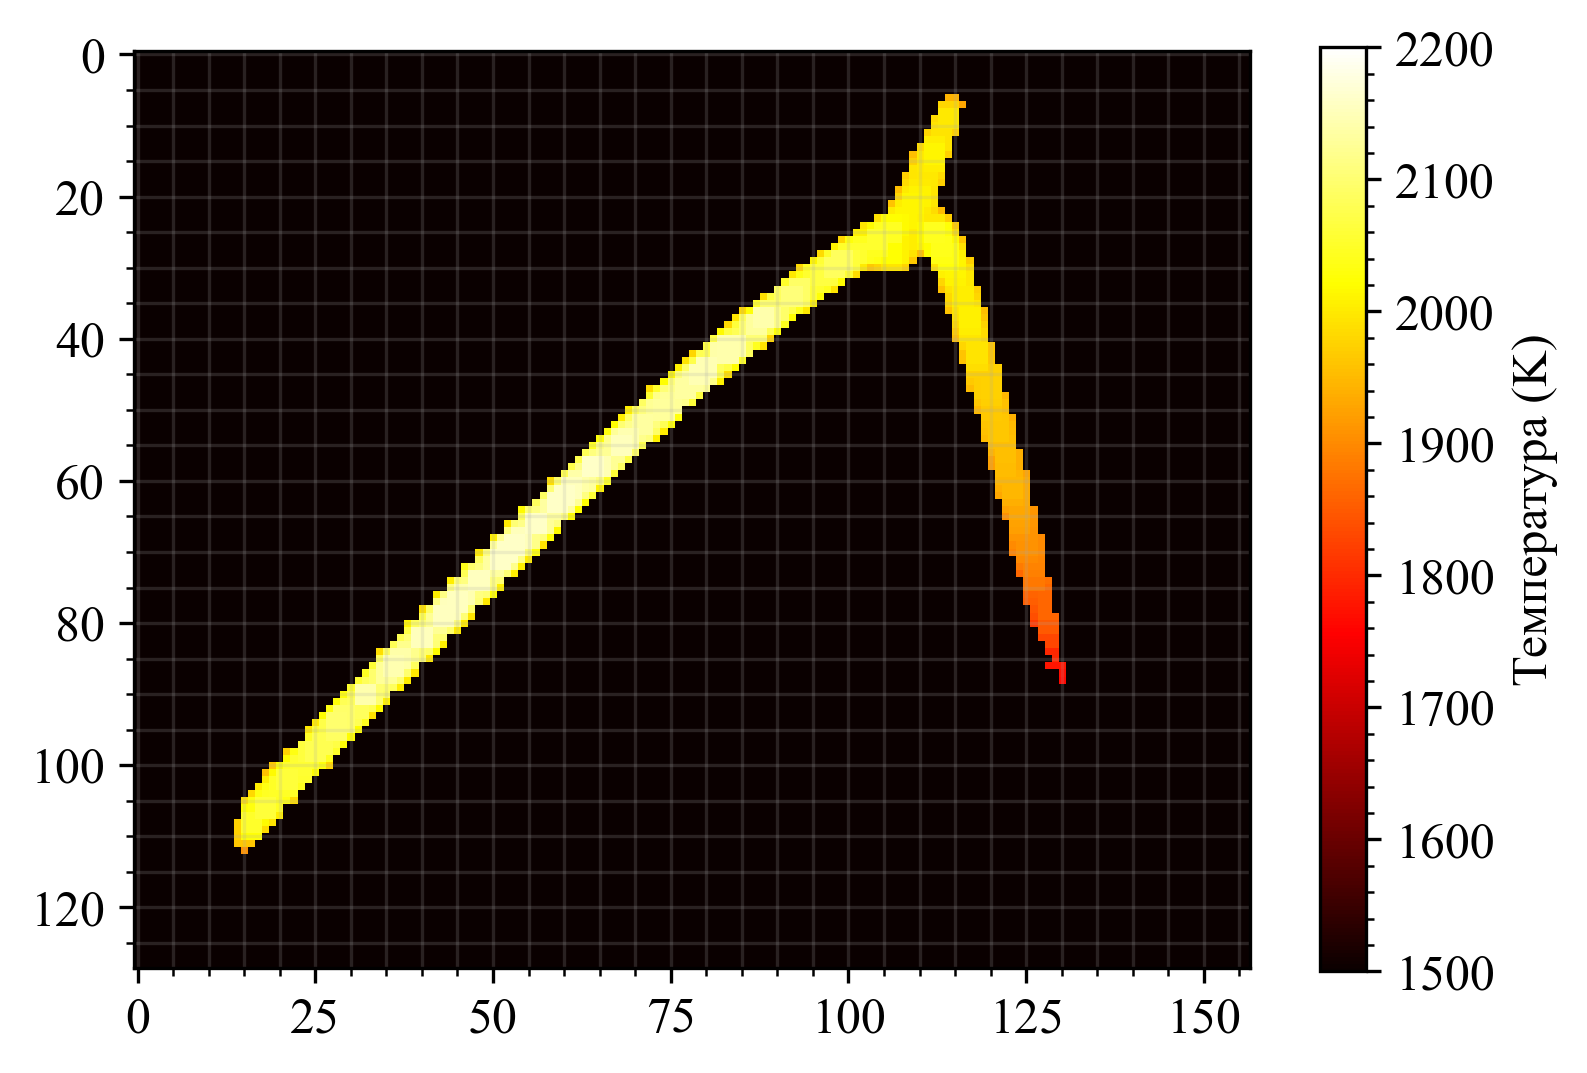

1700 120


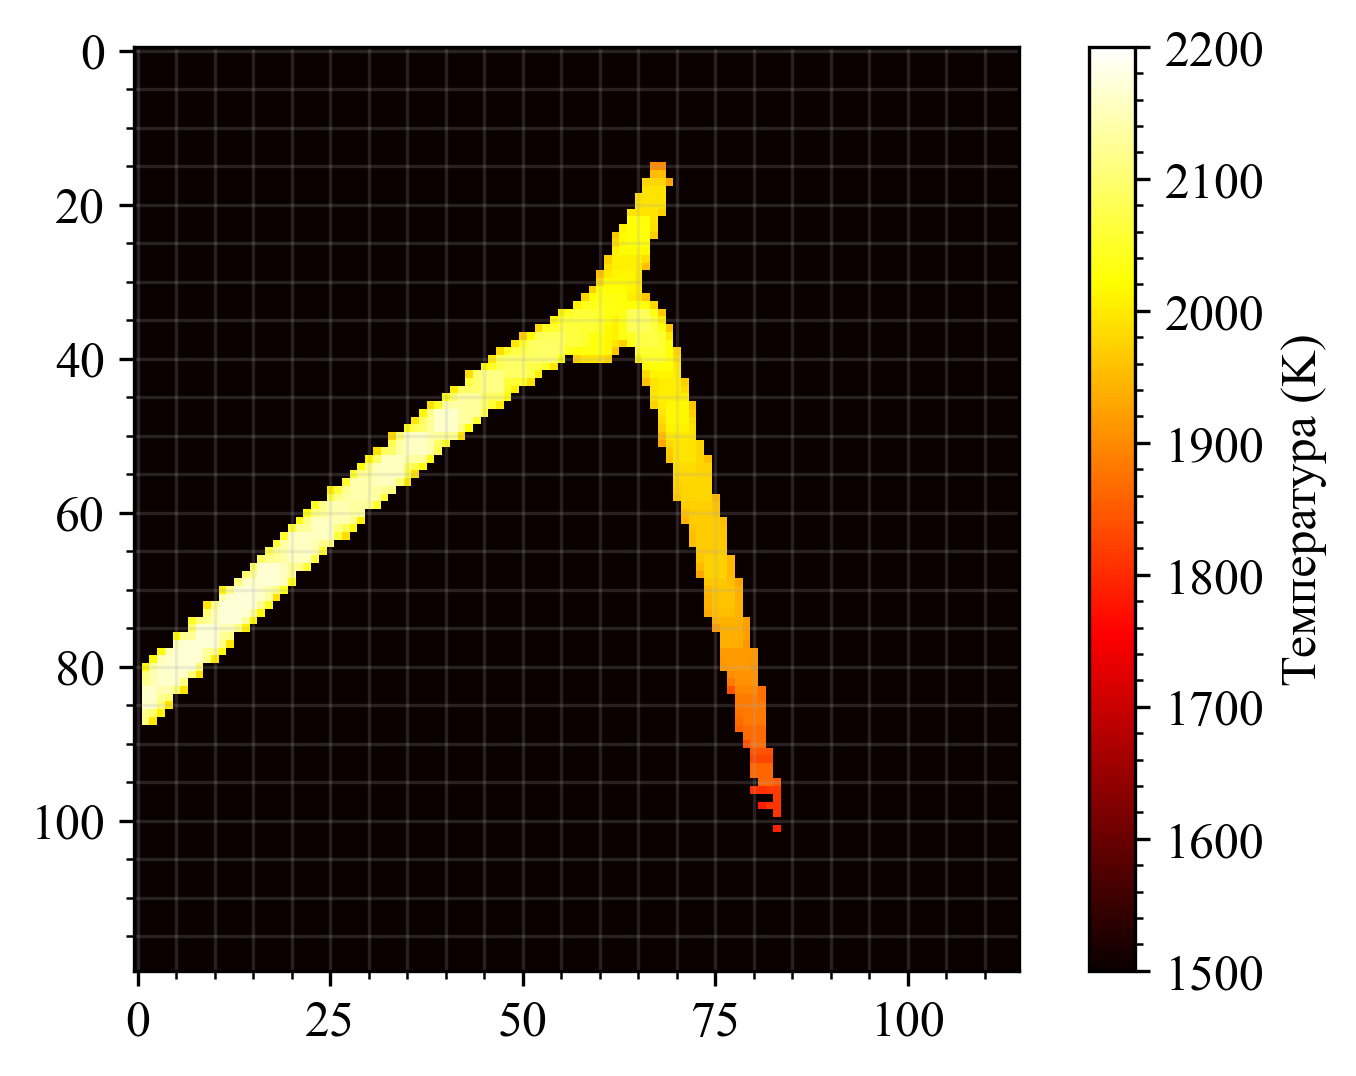

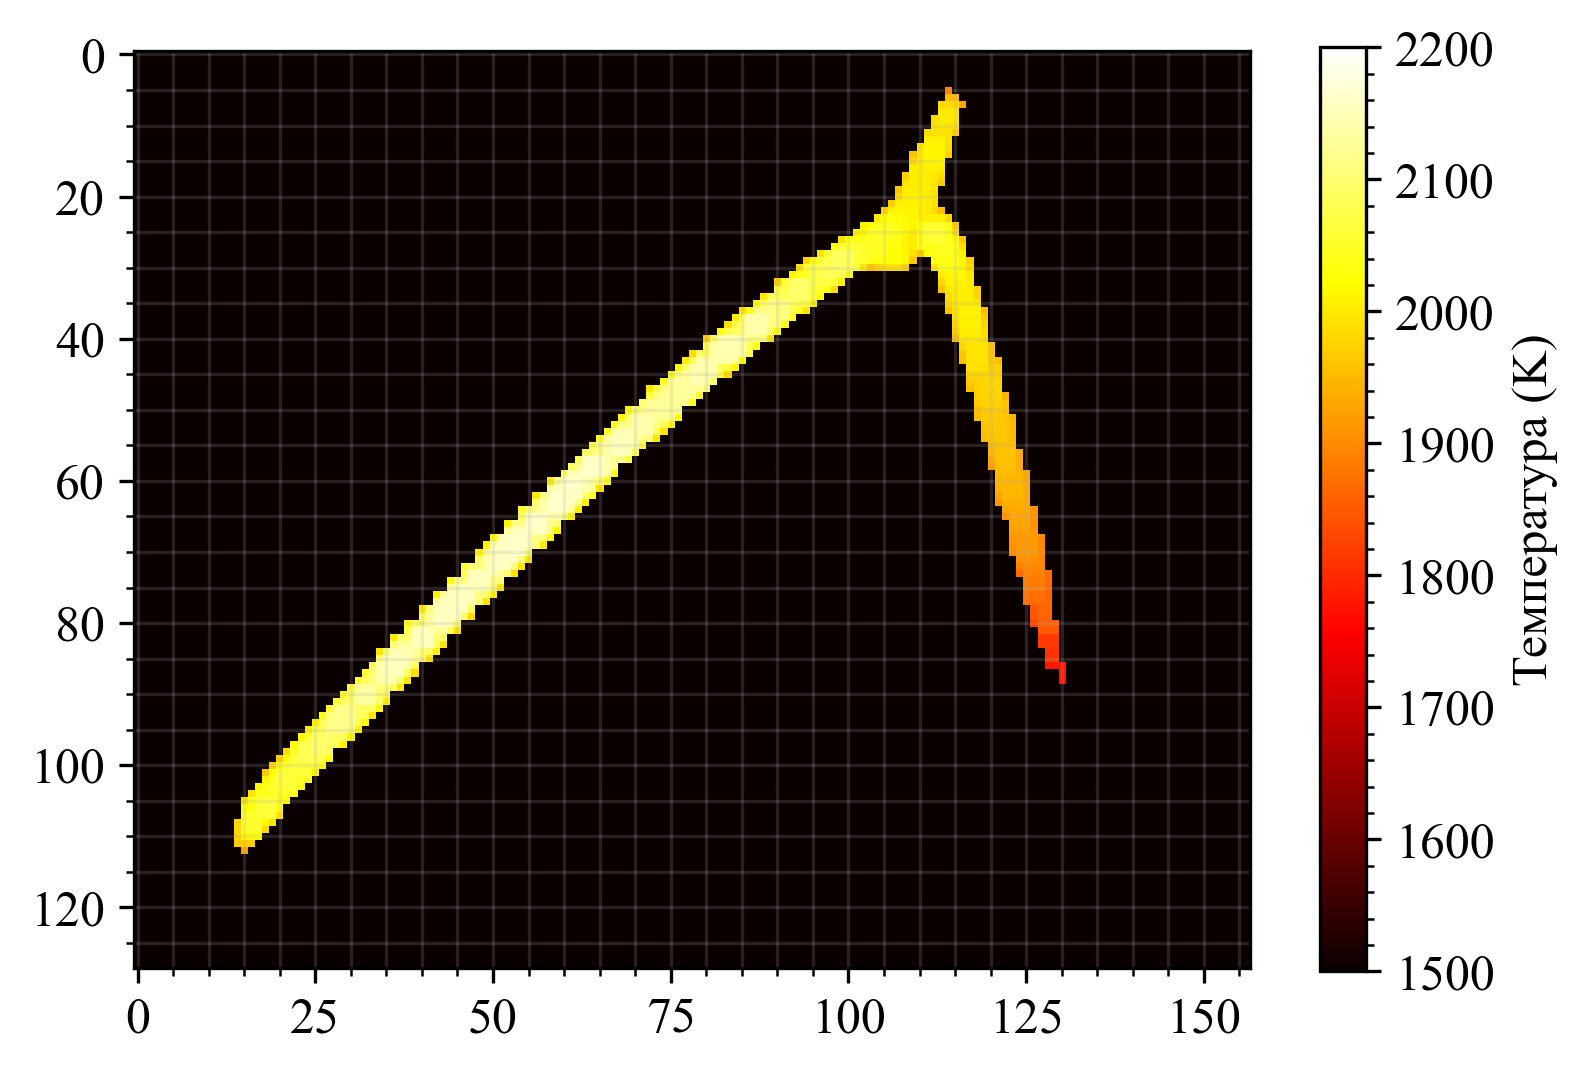

1800 30


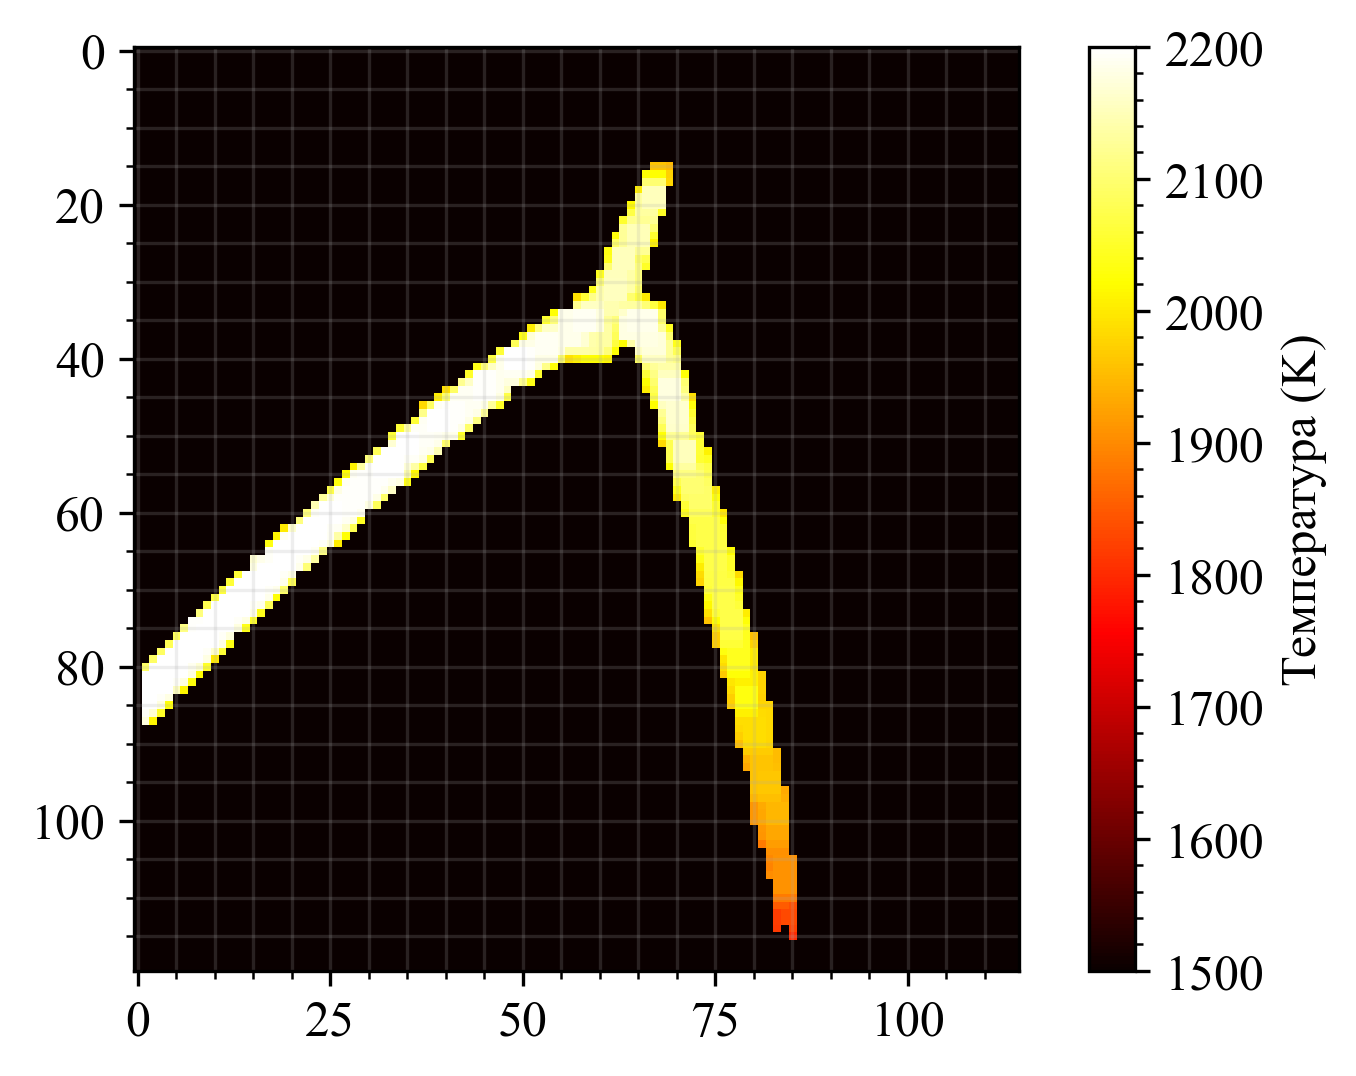

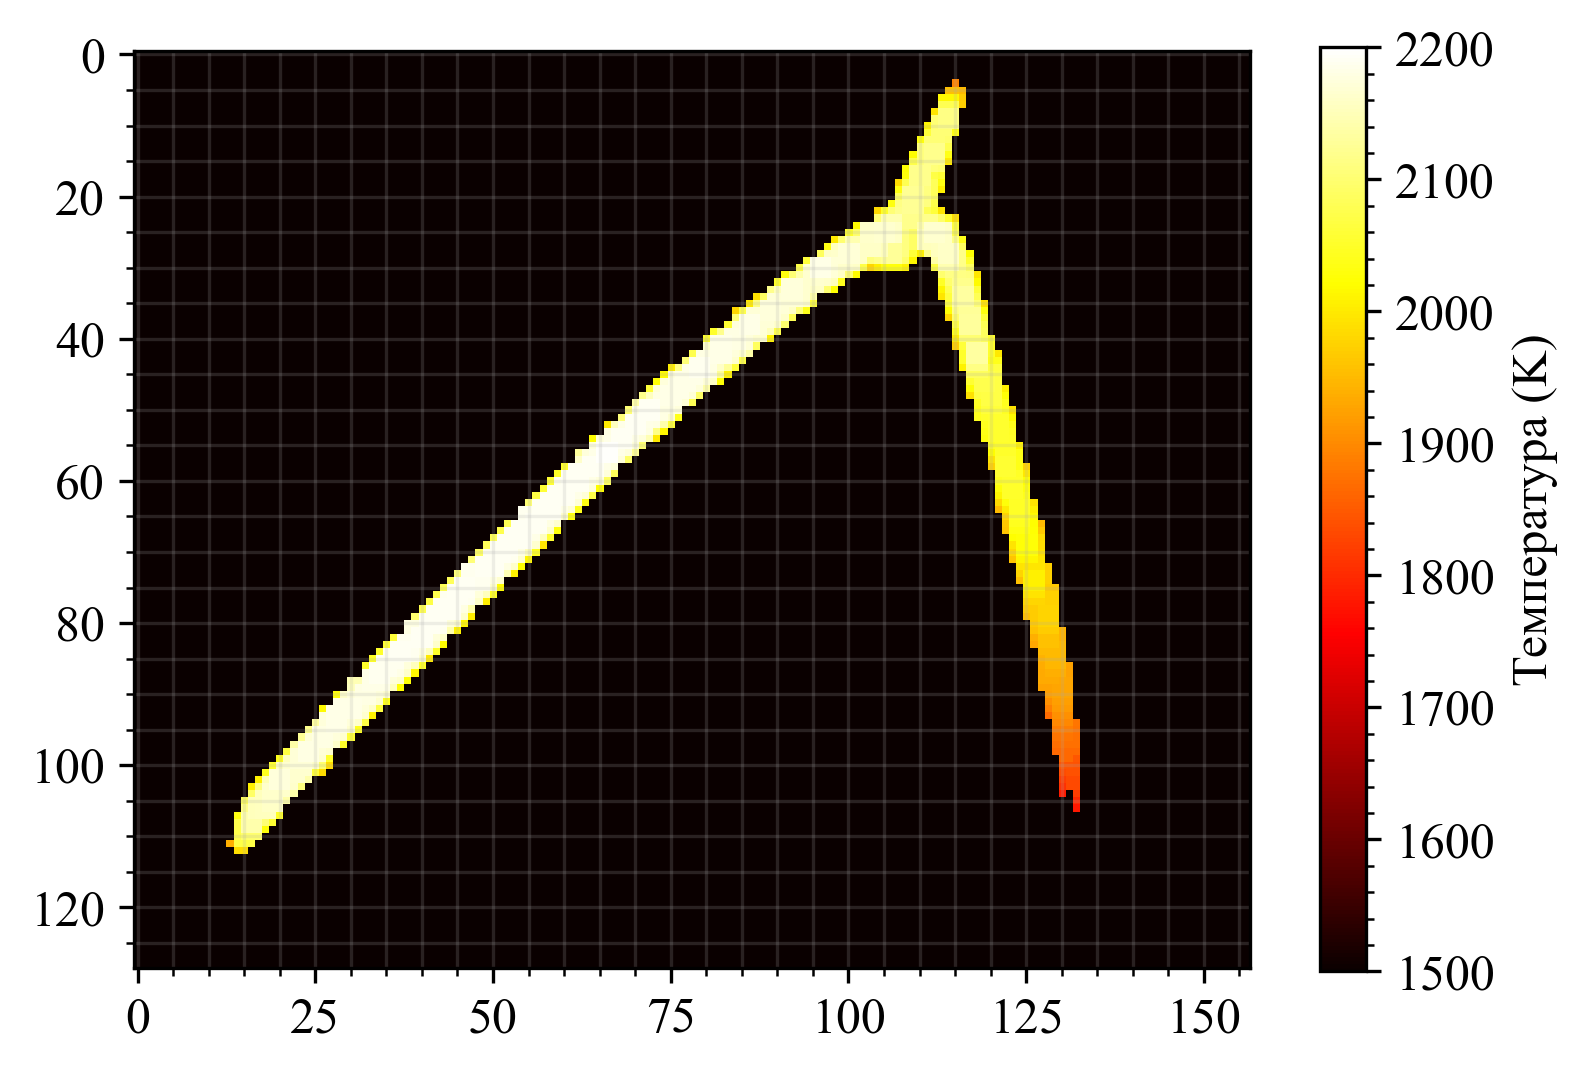

1800 60


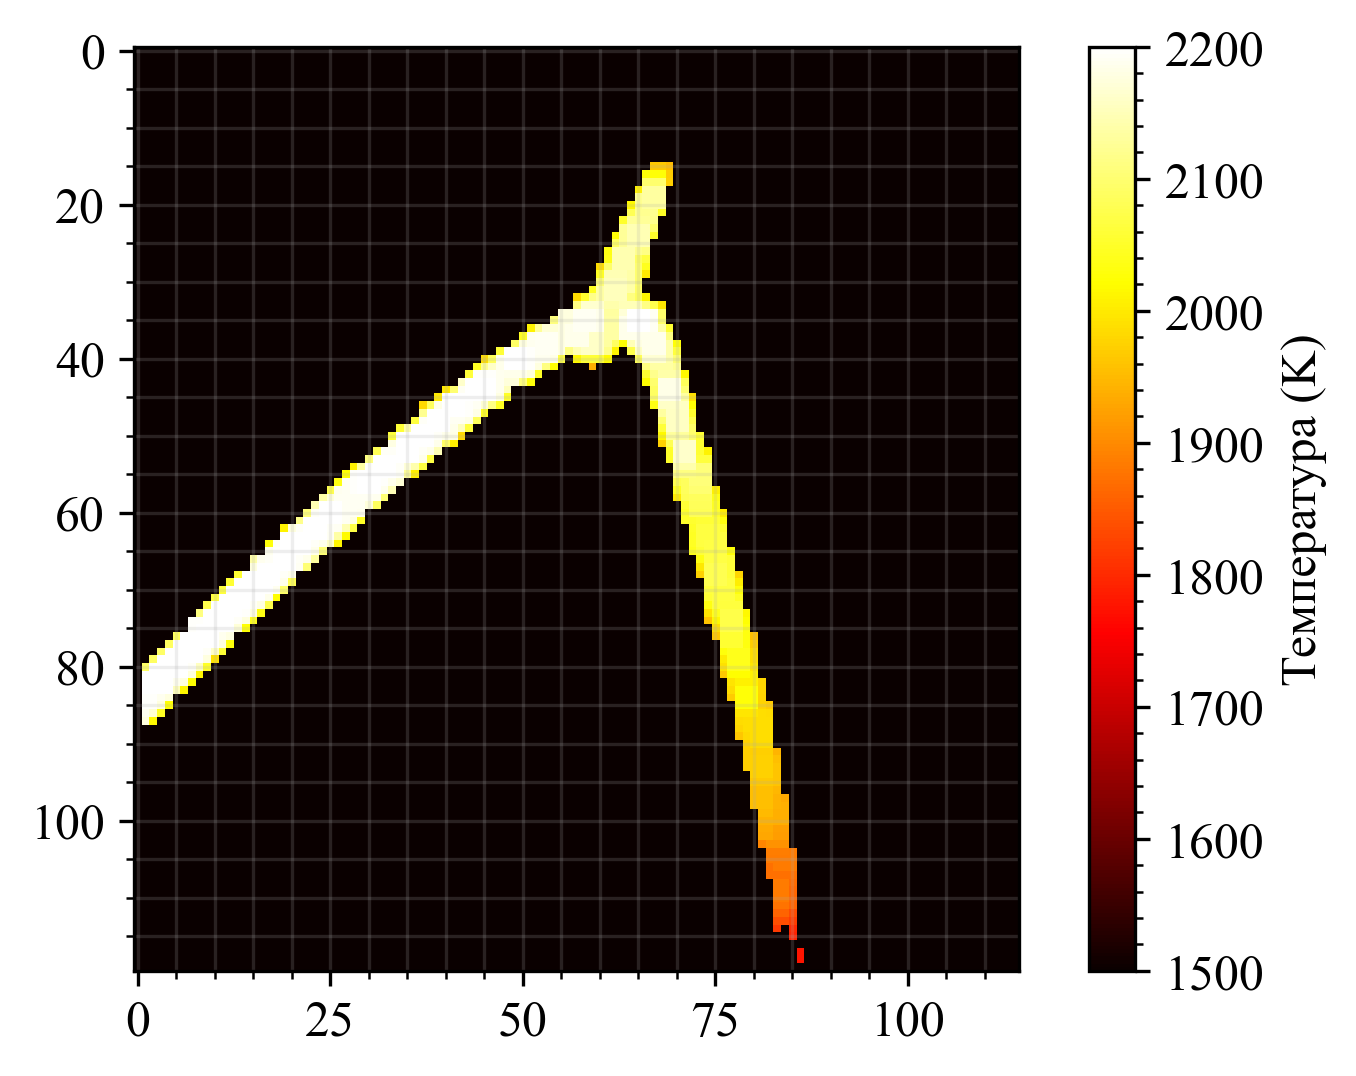

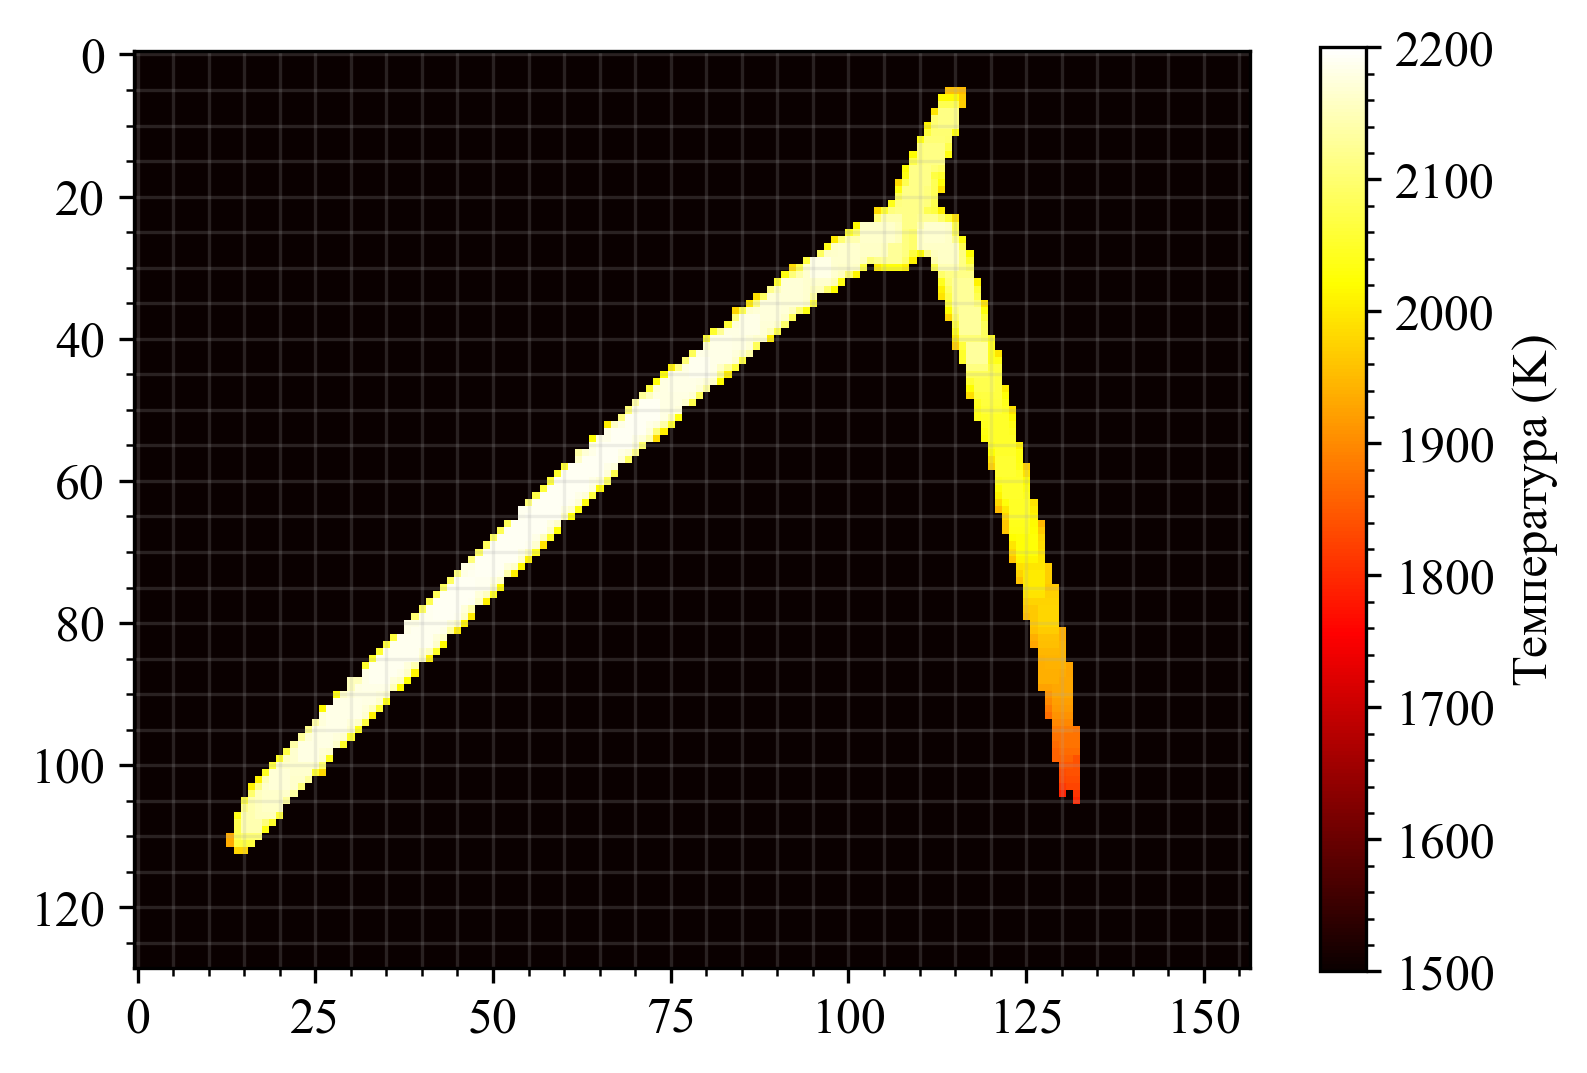

1800 120


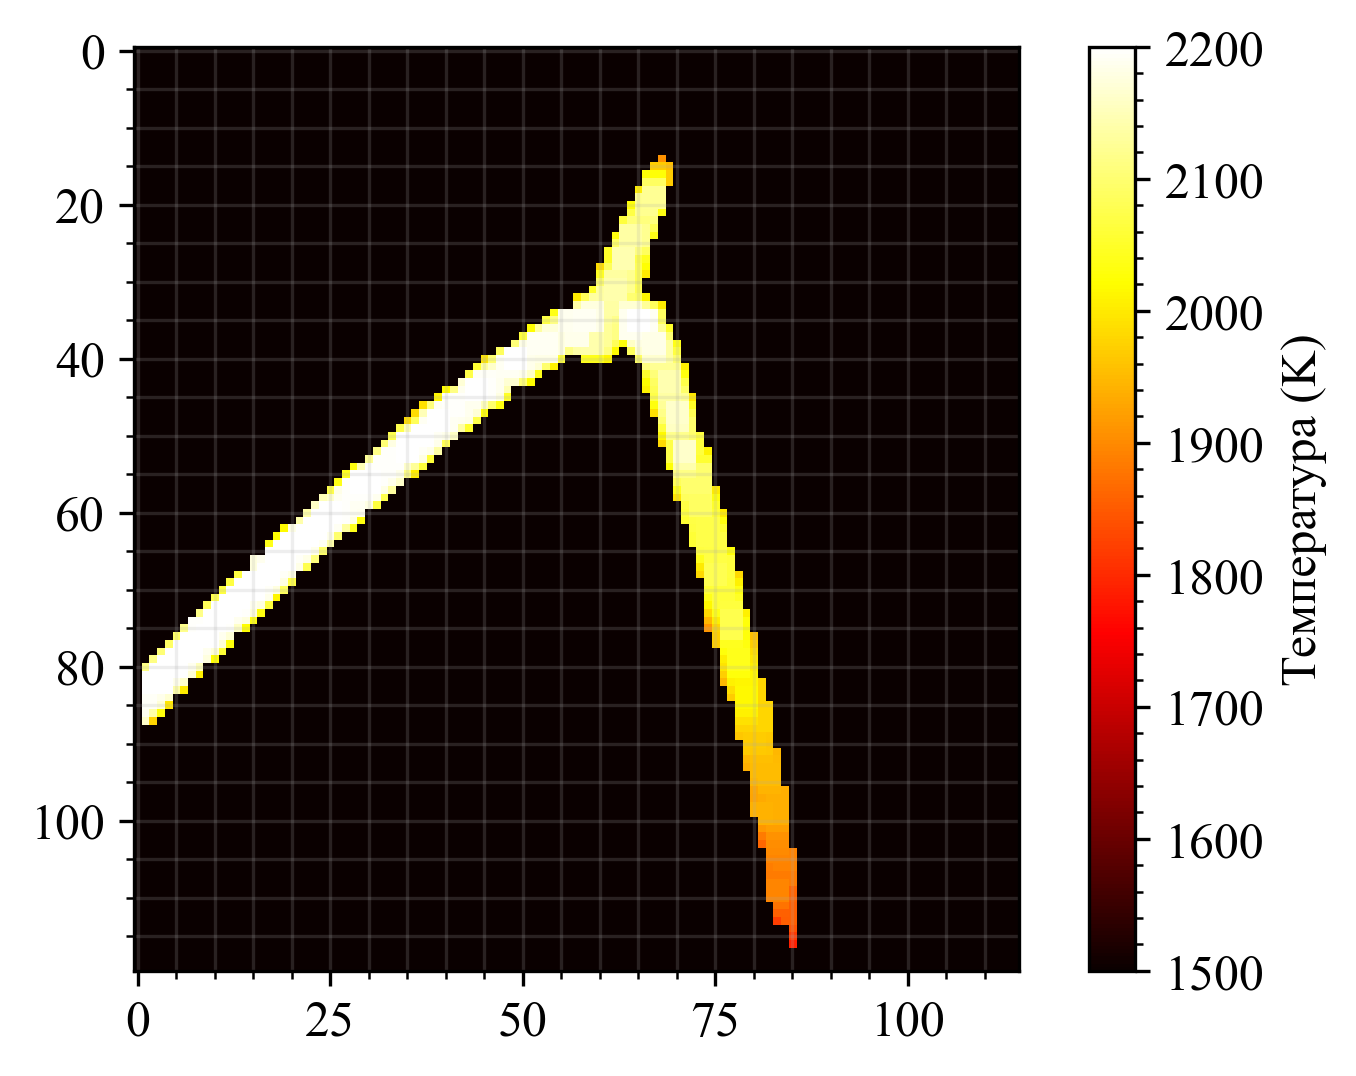

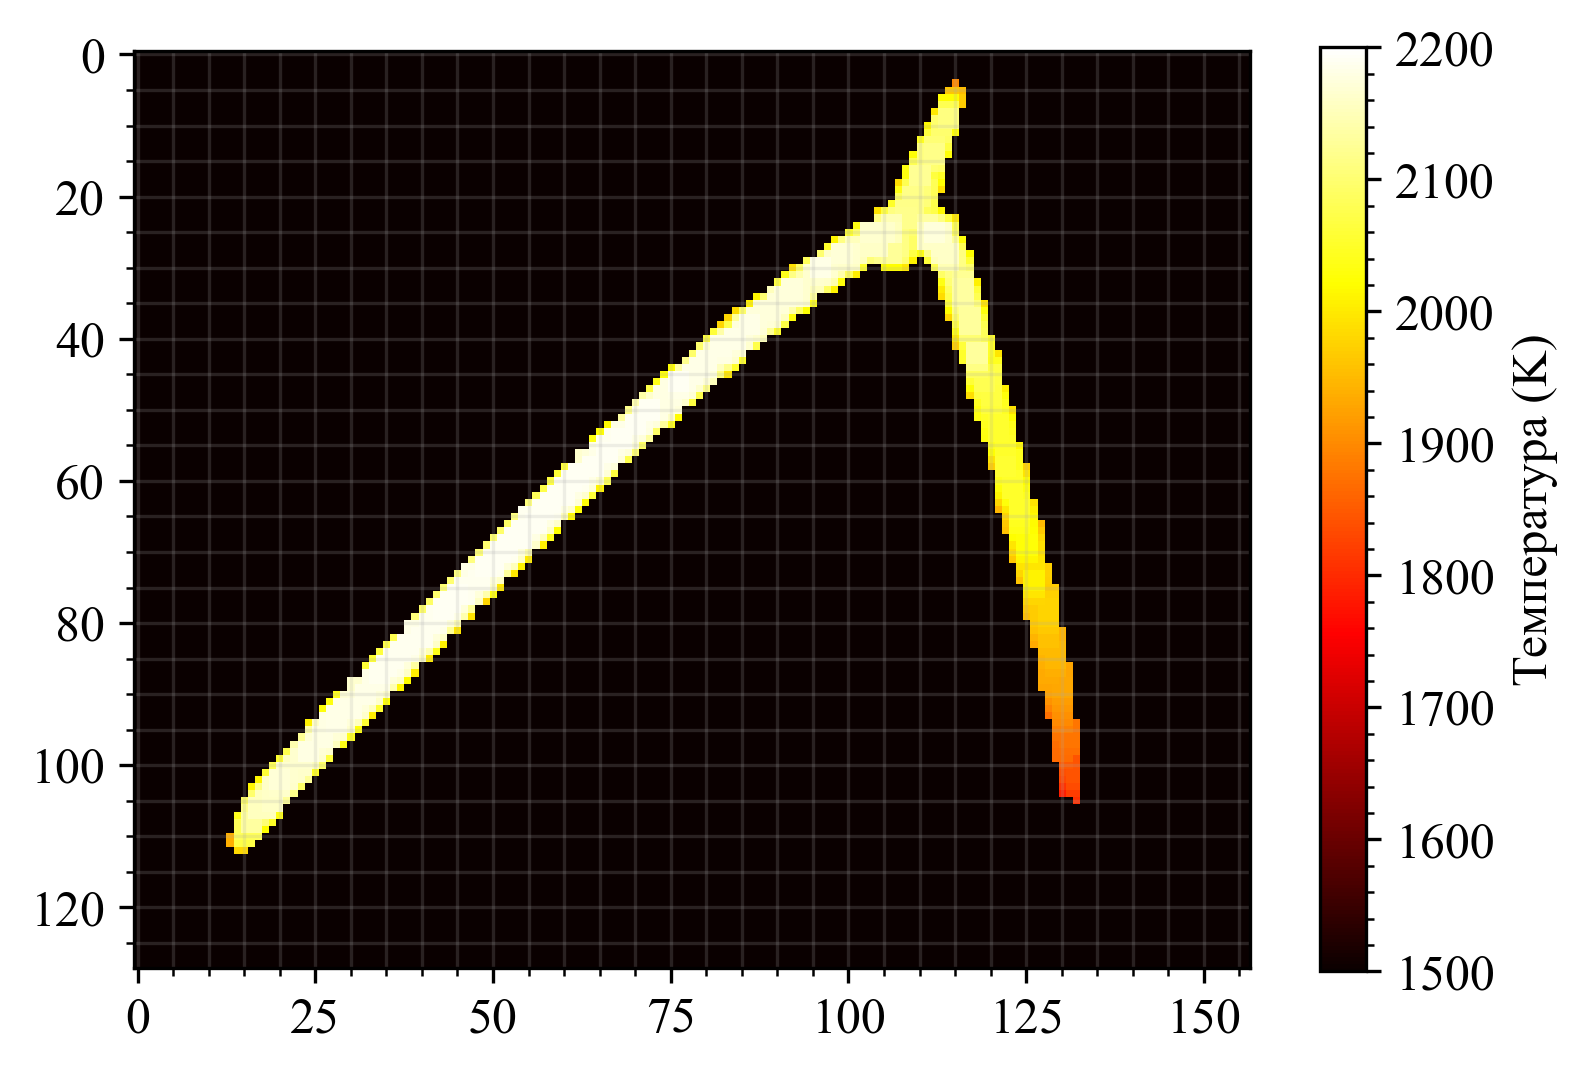

In [37]:
for i in [1500, 1600, 1700, 1800]:
    for t in [30, 60, 120]:
        print(i, t)
        _ = get_temperature_map(f'cathode_11+7/{i}_{t}_original.png', T_bri_11_7, plot=True)
        _ = get_temperature_map(f'cathode_11+7/{i}_{t}_roi.png', T_bri_11_7, plot=True, original=False)